# Hierarchical Methods for N-Body Simulation

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/Users/benburgess/Documents/GitHub/computing-project-benburgess1/BarnesHut')
sys.path.insert(0, '/Users/benburgess/Documents/GitHub/computing-project-benburgess1/FMM')
sys.path.insert(0, '/Users/benburgess/Documents/GitHub/computing-project-benburgess1/BruteForce')
sys.path.insert(0, '/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis')

import BruteForce as BF
import BF2Body
import BarnesHut as BH
import BHDiagrams
import BHvBF
import FMM
import FMMDiagrams
import FMMvBF
import AccelerationErrorGraphs
import StepRuntimeGraphs
import EnergyConservationGraphs

## 1. Introduction

An $N$-body problem involves determining the motion of a system of $N$ bodies, interacting pairwise with each other. An important example comes from astronomy: simulating the motion of stars or other matter under gravity. However, analytical solutions of such $N$-body problems can only be found for $N=2$; in all other cases, the problem must be solved numerically. Furthermore, $N$ can be very large in astronomical simulations; for example, the Milky Way contains $N\sim10^{11}$ stars [1]. Using efficient computational algorithms is therefore imperative to solve these problems.

In this report, I will analyse two algorithms which improve on the $\mathcal{O}(N^2)$ method of calculating all forces directly. The Barnes-Hut algorithm is $\mathcal{O}(N\log N)$ [2], and the Fast Multipole Method can be either $\mathcal{O}(N\log N)$ or $\mathcal{O}(N)$ depending on the implementation details [3,4]. In Section 2, I will detail the theory and mathematics behind the algorithms. In Section 3, I will discuss the details of my implementation of the algorithms, and present animations of the evolution of systems of randomly distributed particles, computed using the algorithms. In Section 4, I will analyse the performance of the algorithms, including their accuracy and execution time, and how they depend on parameters of the algorithms. Finally, I will summarise my work in Section 5.

## 2. Theory and Algorithms

### 2.1 Brute Force

The simplest method of $N$-body simulation is the Brute Force method. This involves calculating the acceleration of each body by computing and summing the forces exerted on it by all of the other bodies directly. In a system of $N$ particles, this requires calculating the force between each of the $\frac{N(N-1)}{2}$ pairs of particles, and so the algorithm has complexity of $\mathcal{O}(N^2)$.

The advantage of the Brute Force method is that it is completely accurate, but at the expense of higher computational requirements than the following algorithms. In a simulation with a low number of particles, the results predicted by the Brute Force method can therefore be compared to those of the other algorithms to assess their accuracy.

### 2.2 Barnes-Hut

The Barnes-Hut algorithm was first presented in [2]. It reduces the number of operations required to calculate the force on a particle by grouping together far-away particles, and calculating the force that would be exerted on the target particle by a single particle located at the centre-of-mass (COM) of the grouped particles, with mass equal to the sum of the masses of all the grouped particles. This is an approximate method; it is equivalent to neglecting the dipole and higher order terms in the multipole expansion of the force from the grouped particles. 

In order to group particles together, they are organised into a 'quadtree' (in 2 dimensions); the 3D equivalent is an 'octree'. In this work, I will only deal with 2D systems, but the code could easily be adapted to work in 3D. The quadtree is constructed by dividing space into four 'nodes', each of which in turn is divided into four more (smaller) nodes, and continuing in this way until each node only contains one particle. The smaller nodes subdividing a larger one are referred to as the 'children' of the larger 'parent', a node with only one particle is a 'leaf', and the original largest node is the 'root'.

Below is an example of a quadtree, showing the positions of the particles and all the nodes that are created.

<IPython.core.display.Javascript object>


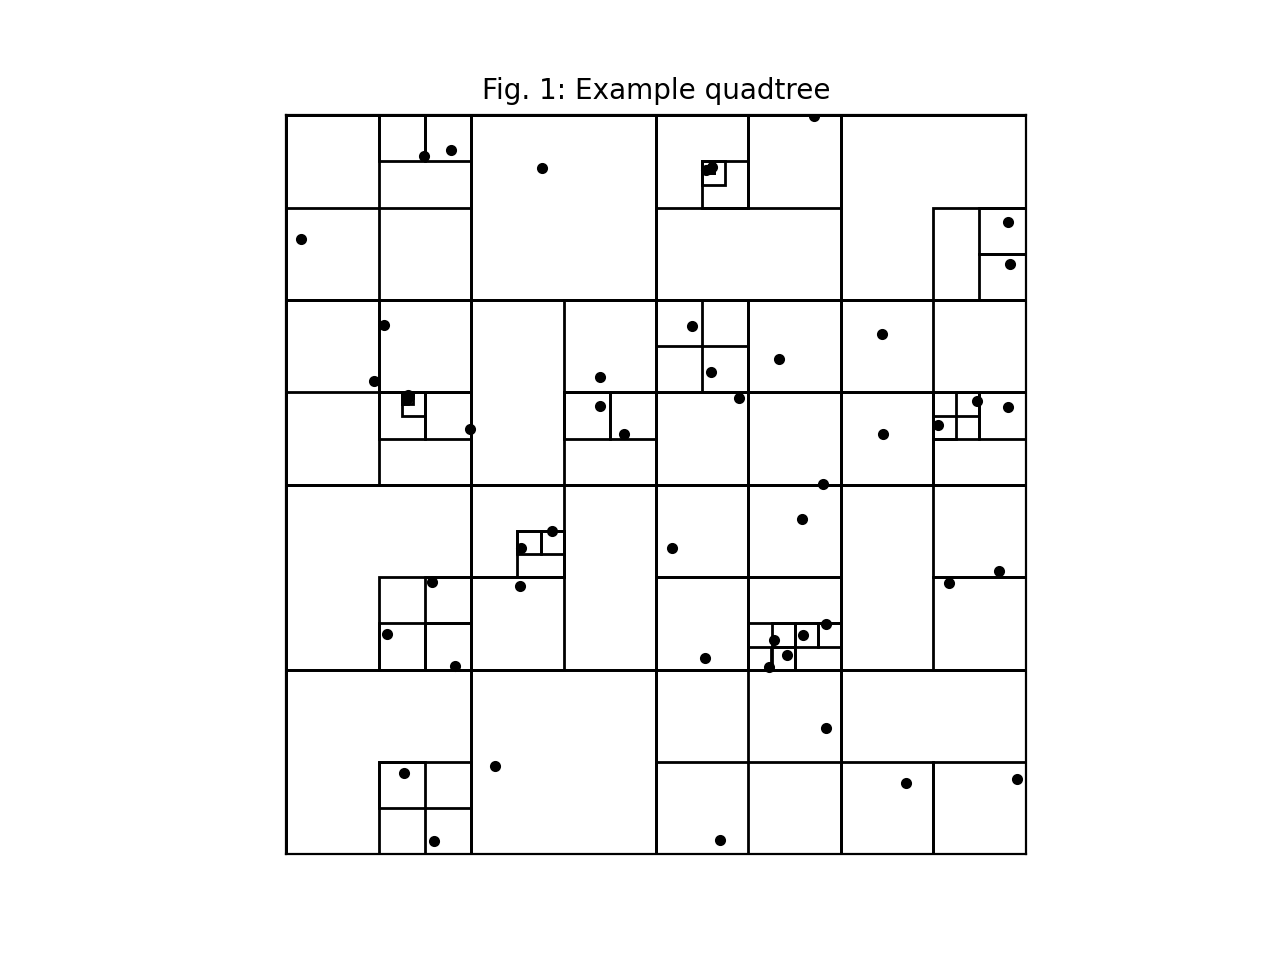

In [21]:
BHDiagrams.visualiseQuadtree(n_particles=50)

Having created the quadtree, the force on a given particle $p$ can be calculated by grouping together all the particles in nodes which are distant enough from $p$. This is determined by the parameter $\theta$; the node is sufficiently well separated from $p$ if:

$$\frac{L}{r}<\theta \tag{1}$$

where $L$ is the side length of the node, and $r$ is the distance from $p$ to the COM of the node. $\theta$ can be chosen to give the desired level of accuracy; lower values of $\theta$ will be more accurate, but require more computational effort. The performance with different values of $\theta$ is discussed in Sections 4.1.1 and 4.2.2. 

To calculate the force on $p$, nodes on successive levels are checked to see if they satisfy $(1)$, starting at the root. If $(1)$ is satisfied by a node, then that node is interacted with; the node's contribution to the force on $p$ is calculated as if all particles in the node were at its COM. If not, then the process is repeated for each of the node's children. This continues down to the leaf nodes, at which point the particles are interacted with directly.

The figure below illustrates how the force on a particle is calculated. For nearby particles, the force is calculated directly (indicated by black arrows). For more distant nodes, which satisfy $(1)$, the force is calculated as if all particles in the node were at the COM of the node; these interactions are indicated by coloured arrows. The COMs are indicated by crosses, and the nodes are coloured according to their size.

<IPython.core.display.Javascript object>


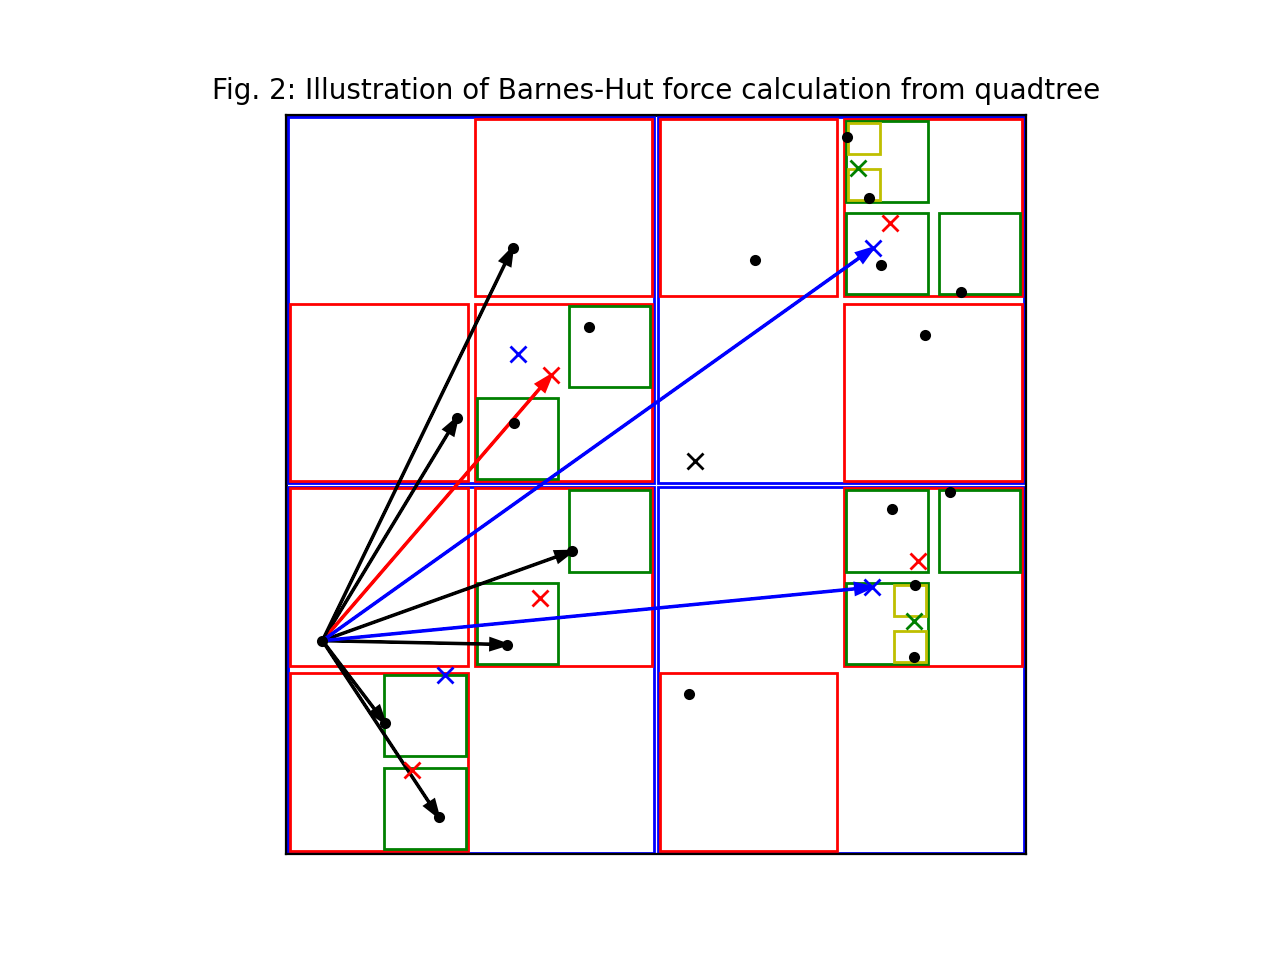

In [22]:
BHDiagrams.visualiseQuadtreeAndForce(n_particles=20,seed=21)

For a $N$ particles, the average inter-particle spacing is $N^{-1/2}$ (each particle occupies an area $N^{-1}$). The typical height of the quadtree (that is, the number of levels before a leaf is reached) is therefore $\mathcal{O}(\log_2(1/N^{-1/2})) = \mathcal{O}(\log N)$ [2]. The numbers of operations required both to build the quadtree, and update all the accelerations by traversing the quadtree, are therefore $\mathcal{O}(N \log N)$. Updating the positions and velocities each require only one operation per particle, and so are $\mathcal{O}(N)$. The overall complexity of the Barnes-Hut algorithm is therefore $\mathcal{O}(N \log N)$.

### 2.3 Fast Multipole Method

The Barnes-Hut algorithm improved on the Brute Force method by replacing particle-particle interactions with particle-node interactions. The Fast Multipole Method (FMM) further improves on this by using multipole and Taylor expansions to calculate node-node interactions. Unlike the other methods, the FMM calculates the potential instead of the force; the acceleration can then be found from the gradient of the potential:

$$\textbf{g}=-\nabla\phi \tag{2}$$

The first step in the FMM is to construct the quadtree in the same way as the Barnes-Hut algorithm. Next, various different expansions of the potential are computed. The following description of the steps involved and mathematical formulae are taken from [3]. For mathematical simplicity, I will work in 2 dimensions; in this case, the potential at $\textbf{r}$ due to a mass $M$ at $\textbf{r}_0$ is:

$$\phi(\textbf{r})=GM\ln(|\textbf{r}-\textbf{r}_0|) \tag{3}$$

This can be simplified by using complex notation. Representing the point $\textbf{r}=(x,y)$ by $z=x+iy$, the potential can be written as:

$$\phi(\textbf{r})=\operatorname{Re}(GM\ln(z-z_0))=\operatorname{Re}(\phi(z)) \tag{4}$$

It is this $\phi(z)$ which is expanded. First, 'outer' multipole expansion coefficients are computed for each node, which can be used to evaluate the potential outside the node due to all of the particles inside it. With the logarithmic potential, for a set of particles with masses $m_i$ and positions $z_i$, the expansion about $z_0$ is given by:

$$\phi(z)=a_0\ln(z-z_0) + \sum_{k=1}^{\infty}\frac{a_k}{(z-z_0)^k} \tag{5}$$

with expansion coefficients

$$a_0 = \sum_{i}m_i \ \ \ \ \  \text{and} \ \ \ \ \  a_k=\sum_{i}\frac{-m_i (z_i-z_0)^k}{k} \tag{6}$$

leaving out the overall factor of $G$; this can be re-inserted later. The expansion is valid provided that $|z-z_0|>|z_i-z_0|$ for all the $z_i$. When implementing the FMM, infinite sums such as in Eqn. $(5)$ are truncated after $n_{\text{terms}}$ terms. The error associated with this is discussed in Section 4.1.2.

In the FMM, the multipole expansions for leaf nodes are calculated first. For nodes on higher levels, instead of calculating the coefficients by summing all of the particles in the node, they are found by 'translating' the coefficients from all of the node's children's expansions; that is, the expansion coefficients about the centre of the parent node are inferred from the children's expansion coefficients about their own centres. This allows the expansion coefficients for all the nodes to be determined in as few operations as possible, without revisiting each particle multiple times. Taking the parent node's centre as the origin, and the child node's as $z_0$, the coefficients are translated by:

$$\phi(z)=a_0\ln(z-z_0) + \sum_{k=1}^{\infty}\frac{a_k}{(z-z_0)^k}=a_0\ln(z) + \sum_{l=1}^{\infty}\frac{b_l}{z^l} \tag{7}$$

where 

$$b_l = -\frac{a_0 z_0^l}{l} + \sum_{k=1}^{l}a_k z_0^{l-k}\binom{l-1}{k-1} \tag{8}$$

with $\binom{l-1}{k-1}$ the binomial coefficient. This formula is used repeatedly to translate all expansions up from the leaf nodes through the tree until the outer expansion coefficients have been calculated for each node.

The outer expansion coefficients give the potential outside a node due to all the particles inside it; however, what is ultimately required to compute the motion of a particle is the potential inside a node due to all the particles outside it. Such an 'inner' expansion (a Taylor expansion) centred on the origin: 

$$\phi(z)=\sum_{l=0}^{\infty}b_l z^l \tag{9}$$

due to an outer expansion centred on $z_0$, has coefficients given by:

$$b_0 = a_0\ln(-z_0) + \sum_{k=1}^{\infty}\frac{a_k}{z_0^k}(-1)^k \ \ \ \ \ \text{and} \ \ \ \ \ b_l = -\frac{a_0}{lz_0^l} + \frac{1}{z_0^l}\sum_{k=1}^{\infty}\frac{a_k}{z_0^k}\binom{l+k-1}{k-1}(-1)^k \tag{10}$$

If the particles from which the multipole expansion is produced are located within a distance $R$ of $z_0$, then the inner expansion is valid within a distance $R$ of the origin provided that $|z_0|>2R$; that is, the region in which the inner expansion is applied must be completely outside the region from which the outer expansion was calculated. In a quadtree with square nodes, this means that inner expansion for a given node $n$ can only be calculated from nodes that do not share a border with $n$. Nodes bordering $n$ are referred to as the 'near neighbours' of $n$. The FMM also defines the 'interaction set' of $n$ as nodes that are children of the near neighbours of the parent of $n$, but are not near neighbours of $n$. These are illustrated in Fig. 3.

Similarly to how the outer expansions were calculated, the inner expansions can be calculated most efficiently by translating coefficients that have already been calculated. The inner expansions are around $z_0$ and the origin are related by:

$$\phi(z)=\sum_{k=0}^{\infty}a_k (z-z_0)^k = \sum_{l=0}^{\infty}b_l z^l \tag{11}$$

where

$$b_l = \sum_{k=l}^{\infty}\binom{k}{l}a_k(-z_0)^{k-l} \tag{12}$$

The inner expansions are calculated from the root node downwards (in the opposite direction to the outer expansions). The inner coefficients are shifted from parent nodes to each of their children, and then the contribution to the child's inner expansion due to the outer expansion from each node in its interaction set is added. This is repeated for the children's children, and so on until the leaf nodes are reached.

As an additional refinement, if at any stage, a node in the interaction set is a leaf (only contains one particle), then instead of calculating how this node contributes to the inner expansion, it is more efficient and accurate to calculate the potential from this particle directly at the end [4]. Children inherit all of their parent's direct nodes, so that when a leaf node is reached, it has a complete list of particles to interact with directly (from the direct nodes and its near neighbours), and an inner expansion accounting for all other particles.

The figures below illustrate the near neighbours and interaction set of nodes on successive levels. The node considered is outlined in green, its near neighbours and direct nodes in red, and its interaction set in blue. In the rightmost figure, all of the nodes that were in the parent's interaction set no longer need to be explicitly considered; all of these particles have already been accounted for by translating the parent's inner expansion to the child. Additionally, some red direct nodes can be seen where a blue interaction set node would normally be expected.

<IPython.core.display.Javascript object>


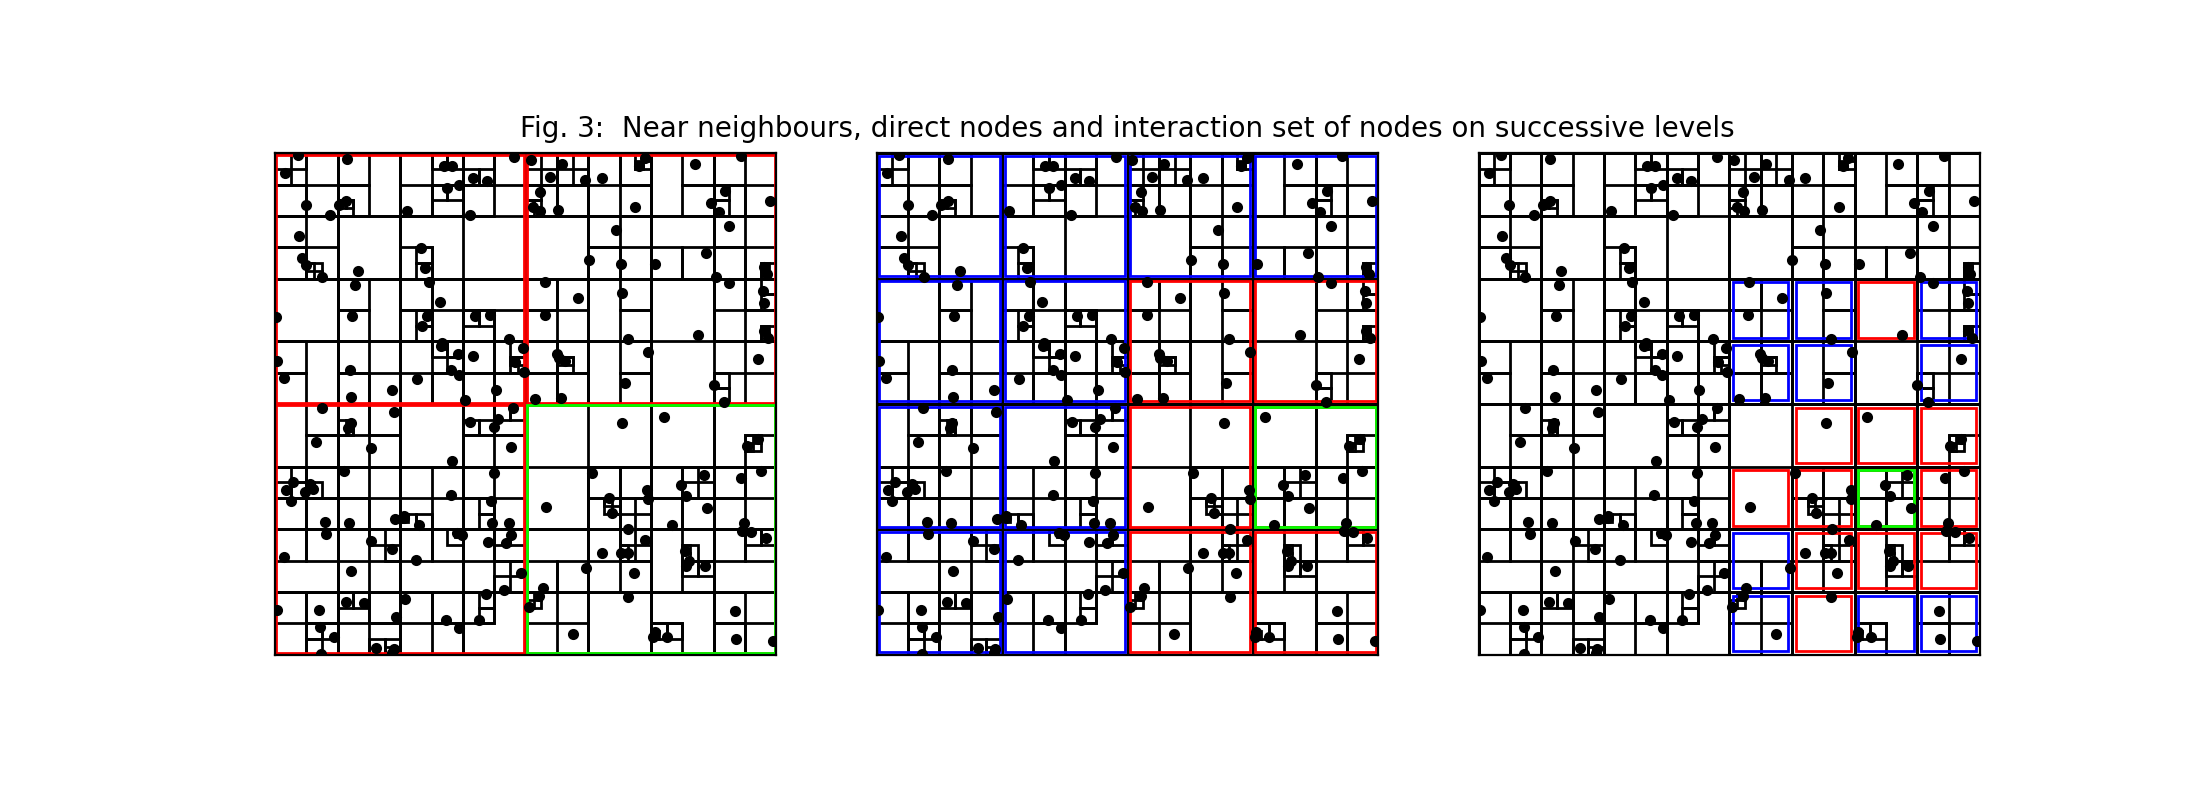

In [23]:
FMMDiagrams.visualiseInteractionSet(n_particles=200)

Once a leaf node is reached, the potential at points inside it can be calculated by directly computing the potential due to particles in the near neighbours and direct nodes, and adding the (real part of the) value from the inner expansion. By evaluating the potential at the three points $(x,y)$, $(x+\delta,y)$ and $(x,y+\delta)$, the gravitational field components can be calculated from:

$$g_x= -\frac{\partial \phi}{\partial x} \approx -\frac{\phi(x+\delta,y)-\phi(x,y)}{\delta} \tag{13a}$$

$$g_y= -\frac{\partial \phi}{\partial y} \approx -\frac{\phi(x,y+\delta)-\phi(x,y)}{\delta} \tag{13b}$$

valid for small $\delta$. The error arising due to the value of $\delta$ is discussed in Section 4.1.2. 

I realised late on in my work that instead of this numerical differentiation, the derivative of the inner expansion (with respect to $z$) could be expressed analytically in terms of the expansion coefficients, and the real and imaginary parts of this could be used to give $g_x$ and $g_y$. This would decrease the time required to calculate the particle accelerations by a factor of $\approx3$, since instead of evaluating the potential at three points, $\textbf{g}$ could simply be evaluated at one point. However, as will be shown in Sections 4.1.2 and 4.2.3, this step dominates neither the error nor the execution time of the FMM, and so I decided not to rewrite the algorithm and repeat all the analysis already carried out for Section 4. It would be wortwhile to implement this change in future work, however.

The limiting step for the complexity of the FMM is the calculation of the (adaptive) quadtree, which is $\mathcal{O}(N \log(N))$ as for the Barnes-Hut algorithm. The other steps all have complexity of $\mathcal{O}(N)$ [5]. 

It is also common to implement the FMM with a uniform quadtree; that is, completely dividing space into small nodes of an equal size which contain an average of $s$ particles each. If the parameters are chosen such that $n_{\text{terms}}=s$, the total complexity is $\mathcal{O}(Ns)$ [3]. However, this method may become innaccurate or inefficient for non-uniform particle distributions. The regions most densely populated with particles will contain nodes with many particles, which are therefore poorly represented by the expansion with only $s$ terms. This can be resolved by using smaller leaf nodes, but this makes constructing the quadtree inefficient, since the less-densely populated regions will be divided into many empty nodes. Even if the particles are initially distributed uniformly, their positions as the simulation progresses may become non-uniform as they are attracted towards each other. I therefore chose to implement the adaptive quadtree, to enable my code to be used without limitations in future work.

The FMM can also be implemented in 3D by expressing the expansions in terms of spherical harmonics. The mathematics involved, although conceptually no harder, does however involve some much lengthier expressions. For simplicity, I therefore chose to just work in 2D with the $\ln(r)$ potential, which fully illustrates the operation and performance of the algorithm. 

### 2.4 Leapfrog Integration

All of the methods described above are techniques for computing the gravitational field; that is, the acceleration of each body. Once this is known, it must be integrated to give the velocities and positions of the bodies. In this work, I will use the leapfrog integration method.

The leapfrog method consists of first applying an initial half-step to the velocity of each particle:

$$\textbf{v}_\frac{1}{2}=\textbf{v}_0 + \textbf{a}_0\frac{dt}{2} \tag{14}$$

where $\textbf{a}_0$ is the acceleration at time $t=0$ evaluated with the particles at positions $\textbf{x}_0$; the subscripts refer to the time, not different particles. $dt$ is the (small) time step, which can be chosen to give the desired accuracy. Then, the position and velocity are updated alternately, 'leapfrogging' over each other:

$$\textbf{x}_{i} = \textbf{x}_{i-1} + \textbf{v}_{i-\frac{1}{2}}dt \tag{15}$$

$$\textbf{v}_{i+\frac{1}{2}} = \textbf{v}_{i-\frac{1}{2}} + \textbf{a}_{i} dt \tag{16}$$

The leapfrog method was chosen for two reasons. Firstly, despite its simplicity, the leapfrog method is second order (the error is proportional to $dt^2$); it is hardly more complicated than the first order Euler method. Secondly, the leapfrog method is also 'symplectic', meaning it conserves the area occupied by the particles in phase space. This means that it possesses global stability, and the energy of the system is approximately conserved [6]. 

## 3. Implementation Details

### 3.1 Brute Force

The implementation of the Brute Force method can be found in the <code>BruteForce.py</code> file. The <code>Particle</code> class is used to store and update the positions and velocities of each particle. The <code>update_accelerations</code> function updates the accelerations of a list of particles by computing all of the forces pairwise. The <code>BF_step</code> function performs one step of leapfrog integration on a system of particles: updating the particle positions, calculating the particle acclerations by summing the force from all other particles, and updating the velocities. The leapfrog parameter $dt$ was chosen to be $0.01$ for all of the algorithms; see section 4.3 for a discussion of this choice of value. Finally, the function <code>initialise_random</code> is defined to create a system with a specified number of particles, with random positions and velocities. Optionally, the initial half-step to the velocity required by the leapfrog method is applied inside this function, so that the system can subsequently be evolved according to the leapfrog method simply by applying <code>BF_step</code>.

For both this and the Barnes-Hut algorithm, I included the ability to choose either the 3D $\frac{1}{r}$ or 2D $\ln(r)$ potential ($\frac{1}{r^2}$ and $\frac{1}{r}$ force respectively) when evaluating interactions. To enable clear comparisons with the implementation of the FMM, I only used the 2D formulae throughout this work unless otherwise specified.

To test that the code was working correctly, I modelled a planet of mass $m$ orbiting a star of mass $M \gg m$, using the 3D $\frac{1}{r^2}$ force law. From Newtonian mechanics, with the initial separation $r\hat{\textbf{x}}$, choosing $\textbf{v}=\sqrt{\frac{GM}{r}}\hat{\textbf{y}}$ gives a circular orbit, with time period $T=2\pi\sqrt{\frac{r^3}{GM}}$. With the values $G=10^{-6}$, $m=1$, $M=10^5$ and $r=0.25$, the predicted time period is $T\approx 2.48$, which is consistent with the Brute Force simulation below.

<IPython.core.display.Javascript object>


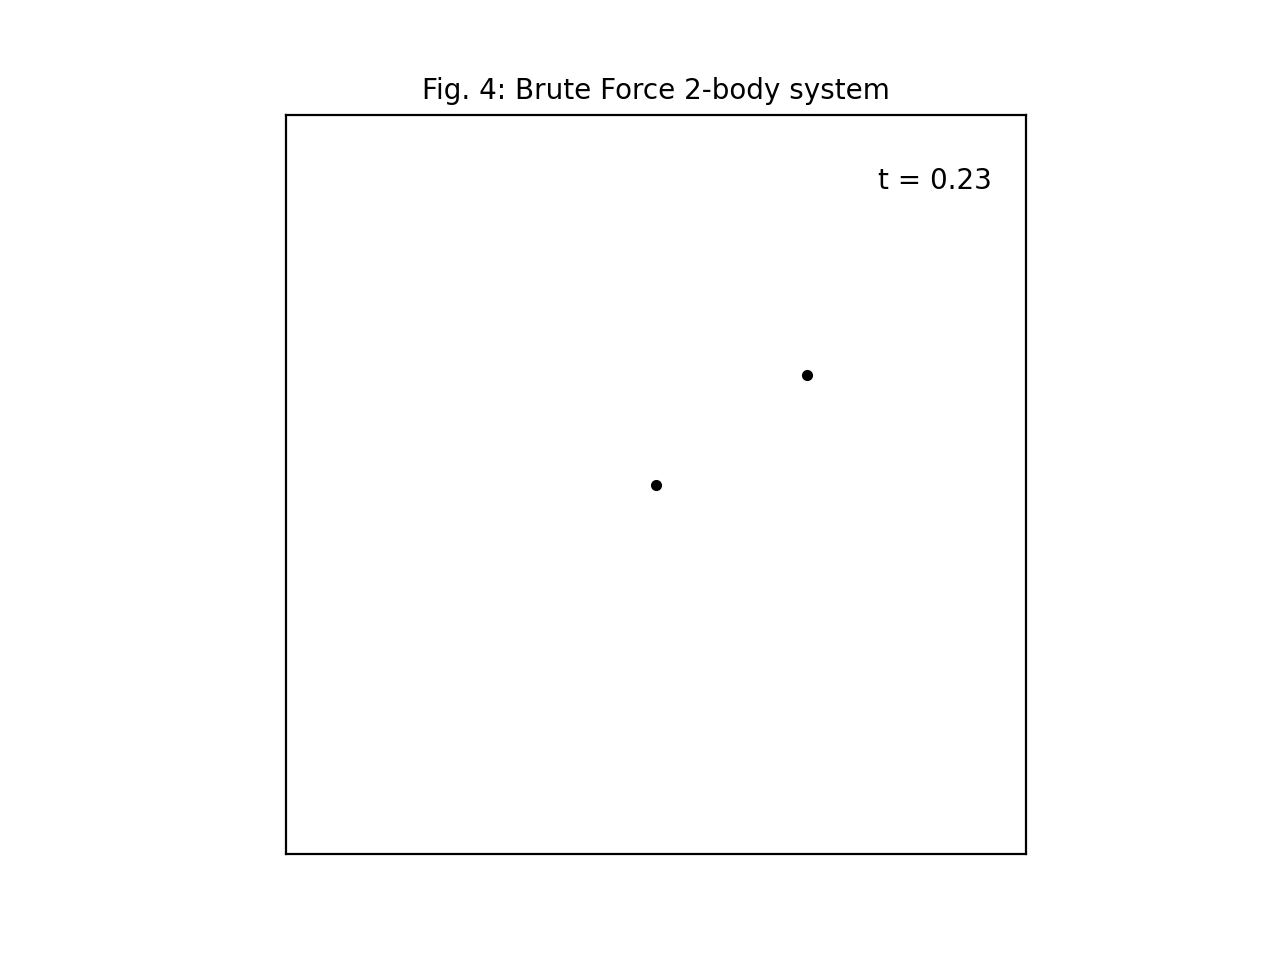

In [39]:
anim = BF2Body.main()
plt.show()

### 3.2 Barnes-Hut

The implementation of the Barnes-Hut method is in the <code>BarnesHut.py</code> file, and is adapted from [7]. 

A <code>Particle</code> class is created similarly to the Brute Force method, and also includes the <code>update_a</code> method using the Barnes-Hut algorithm to calculate the acceleration of the particle. Additionally, the <code>Node</code> class is used to define the properties of the nodes, and recursively construct the quadtree when called. 

The function <code>BH_step</code> performs one step of leapfrog integration on a system of particles, consisting of updating all particle positions, rebuilding the quadtree, updating the accelerations and updating the velocities. An <code>initialise_random</code> function is defined as in the Brute Force implementation, the only difference being that the accelerations used to apply the velocity half-step are calculated using the Barnes-Hut algorithm.

$\theta=0.7$ gives an error of $\sim1\%$ [7], and has been used as the default value in all code here unless otherwise specified. The relationship between $\theta$ and the error is discussed in Section 4.1.1.

To check that the implementation is functioning correctly, its results can be compared to those from the Brute Force method. In the animation below, the black dots and red crosses represent the particle positions calculated from the Barnes-Hut and Brute Force methods respectively. These agree very well initially, although the inaccuracies in the approximate Barnes-Hut method are evident at later times.

<IPython.core.display.Javascript object>


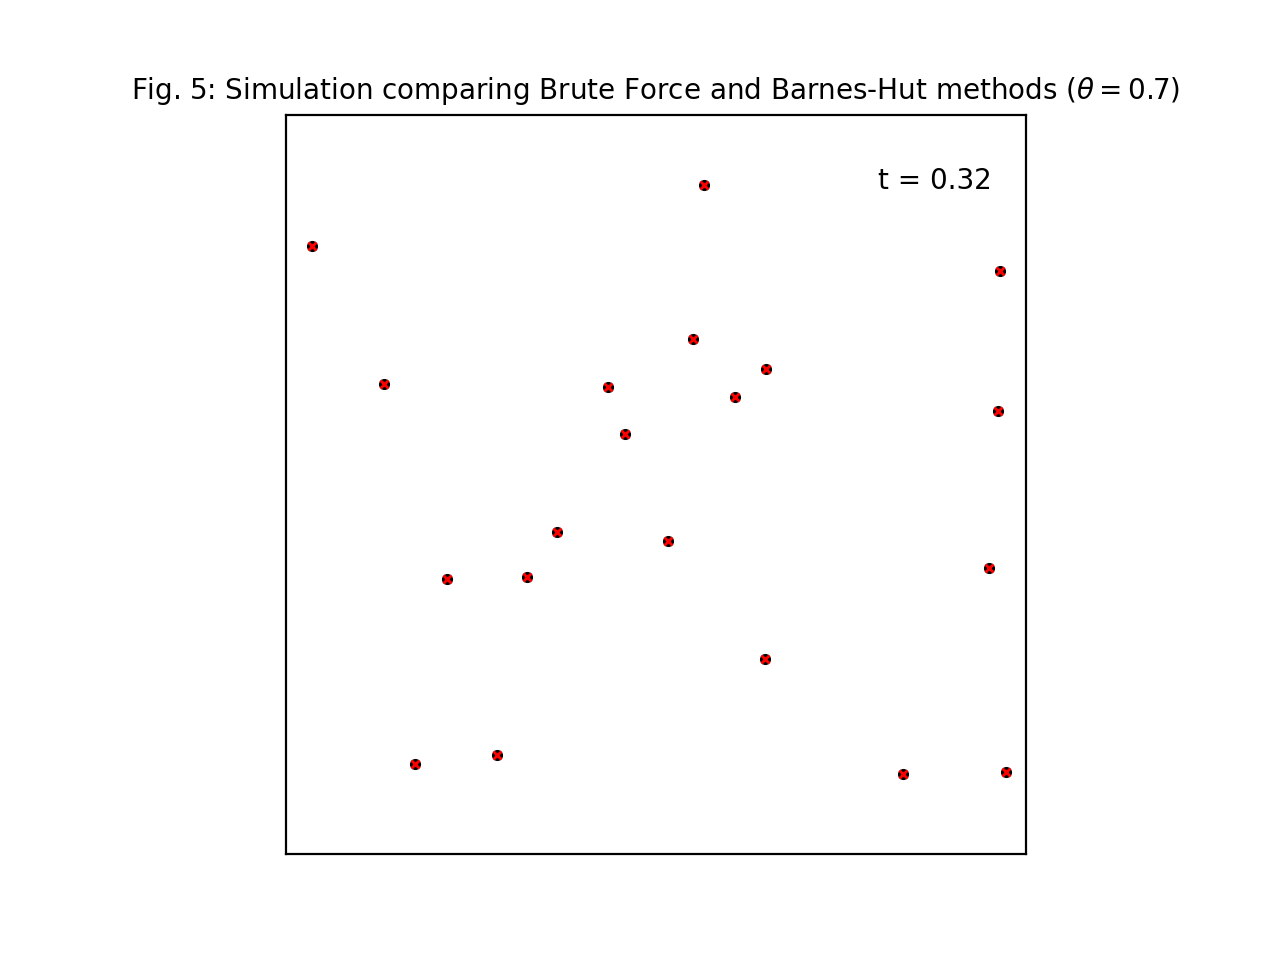

In [40]:
anim = BHvBF.simulate7()
plt.show()

As an additional check, running the Barnes-Hut algorithm with $\theta=0$ should give results that exactly agree with the Brute Force method (since $\theta=0$ means that no nodes satisfy the $\frac{L}{r}>\theta$ condition, so the force is calculated from all particles directly). The animation below does confirm this behaviour. Differences only arise between the two simulations if particles are scattered outside of the initial area on which the quadtree in the Barnes-Hut algorithm is defined; they will then not be assigned to a node, and so their contribution to the force on the other particles won't be included. 

<IPython.core.display.Javascript object>


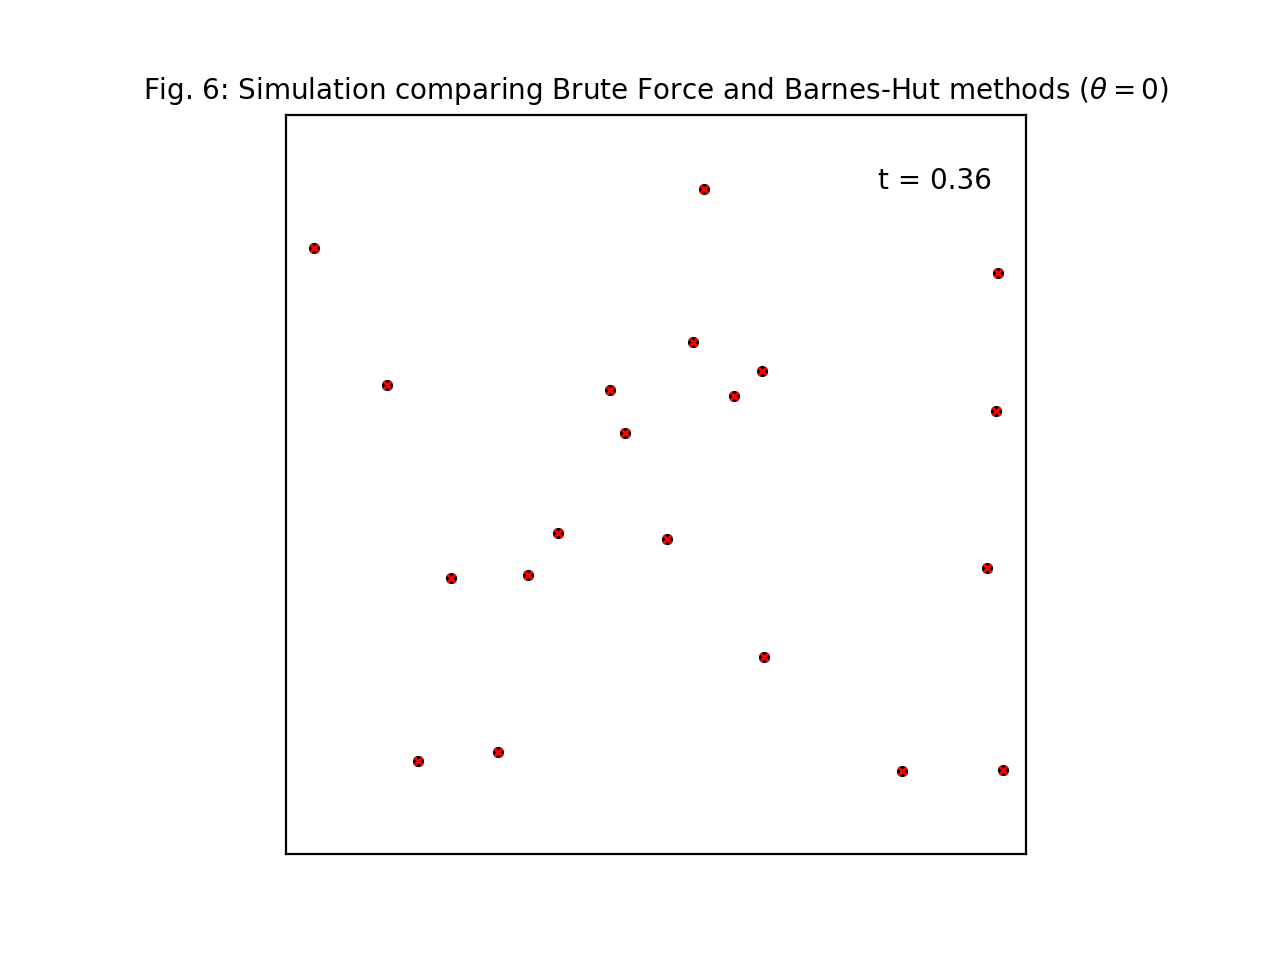

In [41]:
anim = BHvBF.simulate0()
plt.show()

### 3.3 Fast Multipole Method

The FMM is implemented in the <code>FMM.py</code> file, and is adapted from [8]. 

There is a <code>Particle</code> class similar to that in the Barnes-Hut implementation, but with acceleration calculated from the gradient of the potential calculated by the FMM algorithm. As in the Barnes-Hut implementation, there is a <code>Node</code> class, which builds the quadtree when called. This <code>Node</code> class also includes functions for determining the near neighbours, interaction set and direct nodes for each node, as well as calculating all outer and inner expansion coefficients recursively. The <code>Expansion</code> class is used for computing, storing and translating the expansion coefficients using the formulae in Section 2.3.

The <code>quadtree</code> function builds the quadtree, and then determine the near neighbours, direct nodes and interaction set of each node, before computing all outer and inner expansion coefficients recursively. The <code>FMM_step</code> function performs a step of leapfrog integration, analagous to the <code>BH_step</code> function in the Barnes-Hut implementation, except that the particle acclerations are updated using the FMM, and the additional information is computed by the <code>quadtree</code> function. An <code>initialise_random</code> function is defined as in the implementations of the other algorithms, the only difference being that the velocity half-step is applied using accelerations calculated using the FMM.

By default, the implementation runs with paramters $n_{\text{terms}}=5$, with an associated error of $\sim 0.1 \%$, and $\delta=10^{-10}$, with negligible error. These errors are discussed in Section 4.1.2.

The animation below compares its performance to the Brute Force method. As with the Barnes-Hut method, there is initially very good agreement, before some small inaccuracies become apparent later on.

<IPython.core.display.Javascript object>


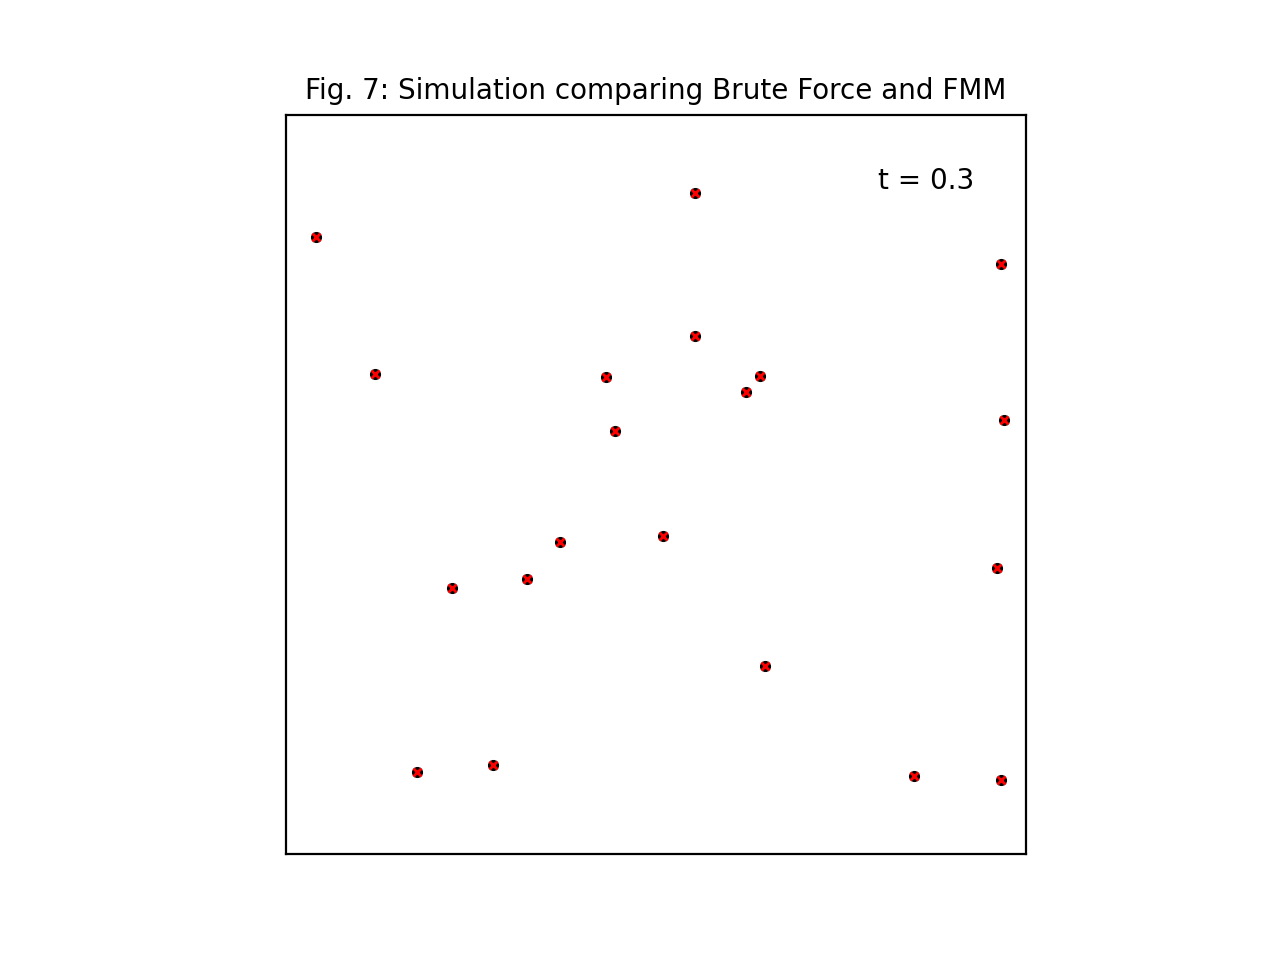

In [42]:
anim = FMMvBF.main()
plt.show()

## 4. Performance

### 4.1 Accuracy

The accuracy of each algorithm was determined by comparing each to the results of the Brute Force calculations. In each case, a random set of particles was initialised, and each particle's acceleration calculated. The accuracy of the algorithm is then determined by the fractional RMS error in the acceleration:

$$\epsilon=\sqrt{\frac{1}{N}\sum_{i=1}^{N}\left(\frac{|\textbf{a}_i^{BH/FMM}-\textbf{a}_i^{BF}|}{|\textbf{a}_i^{BF}|}\right)^2} \tag{17}$$

where $N$ is the number of particles, and $\textbf{a}_i^X$ is the acceleration of the $i$-th particle calculated using the $X$ method.

#### 4.1.1 Barnes-Hut

<IPython.core.display.Javascript object>


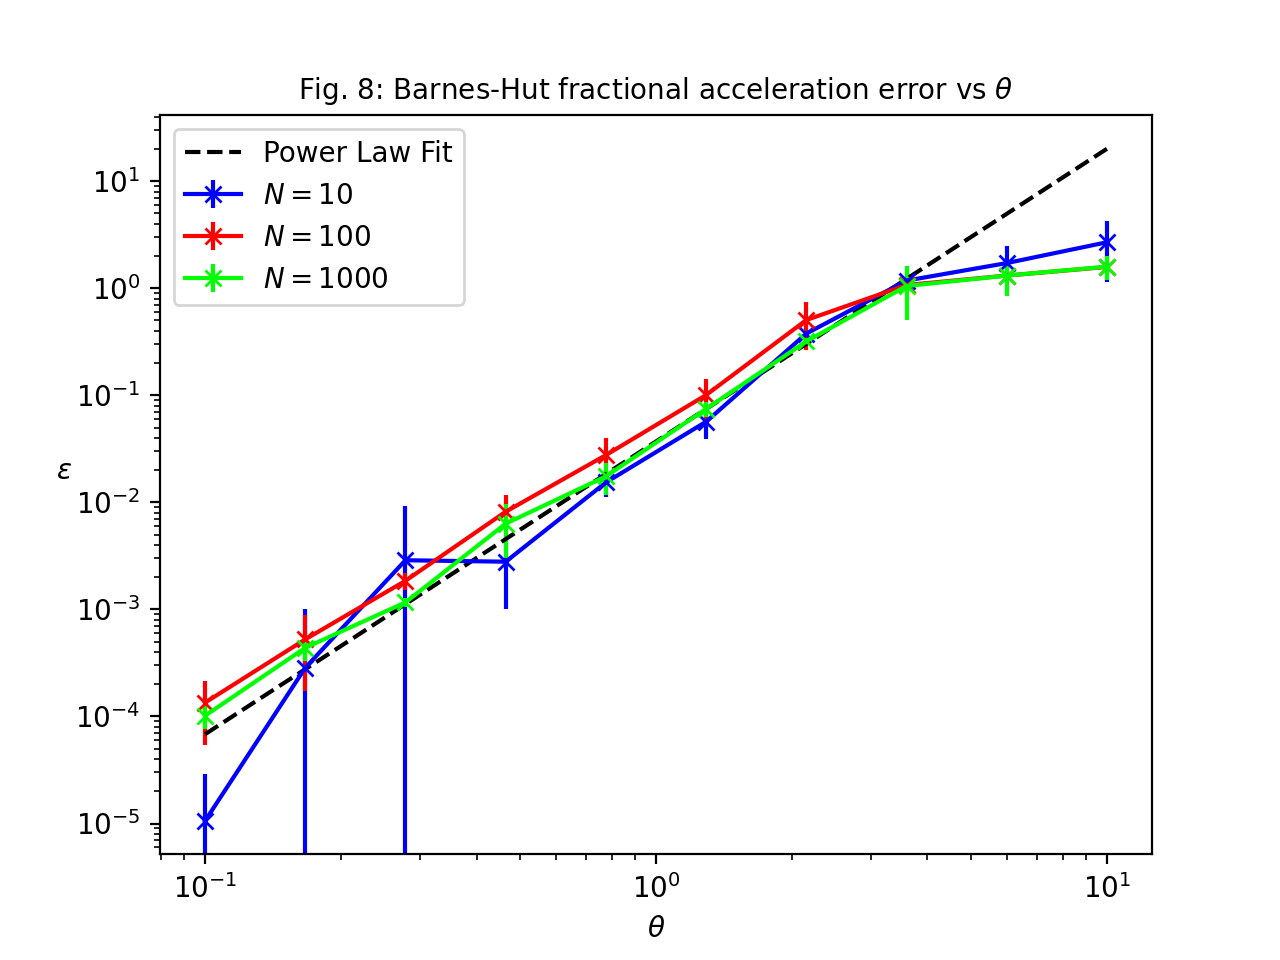

Power law exponent n = 2.7340821151008994 +/- 0.09727072433277652


In [28]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/BHAccError.npz')
AccelerationErrorGraphs.BH_Graph(data)

The graph above shows the dependence of $\epsilon$ on $\theta$ for the Barnes-Hut algorithm. The large error bars on some points in the $N=10$ dataset are due to the fact that on some runs, the arrangement of particles was such that no nodes met the $\frac{L}{r}<\theta$ condition, and so all interactions were calculated directly. The accelerations were therefore the same as those calculated by the Brute Force method (up to the $\sim10^{-16}$ precision of the computer), leading to some anomalously low values of $\epsilon$.

The data are consistent with the value of $\epsilon \sim 1 \%$ for $\theta=0.7$ from [7].

The log-log plot is linear until the last few data points, indicating a power law relationship $\epsilon \propto \theta^n$. The <code>scipy.optimise.curve_fit</code> function was used to fit such a relationship over this range of $\theta$ to the $N=1000$ data, which is presumed to be the most reliable as it is based off the largest number of particles. This gives that $\epsilon$ approximately scales as $\theta^3$. At high values of $\theta$, $\epsilon$ levels off because virtually all nodes already obey the $\frac{L}{r}<\theta$ condition, and so increasing $\theta$ further doesn't affect how the force is computed.

The figure also shows that, for these values of $N$, $\epsilon$ does not depend on $N$. Larger $N$ could not be investigated due to the long execution time of the Brute Force method for $N>10^3$.

#### 4.1.2 FMM

<IPython.core.display.Javascript object>


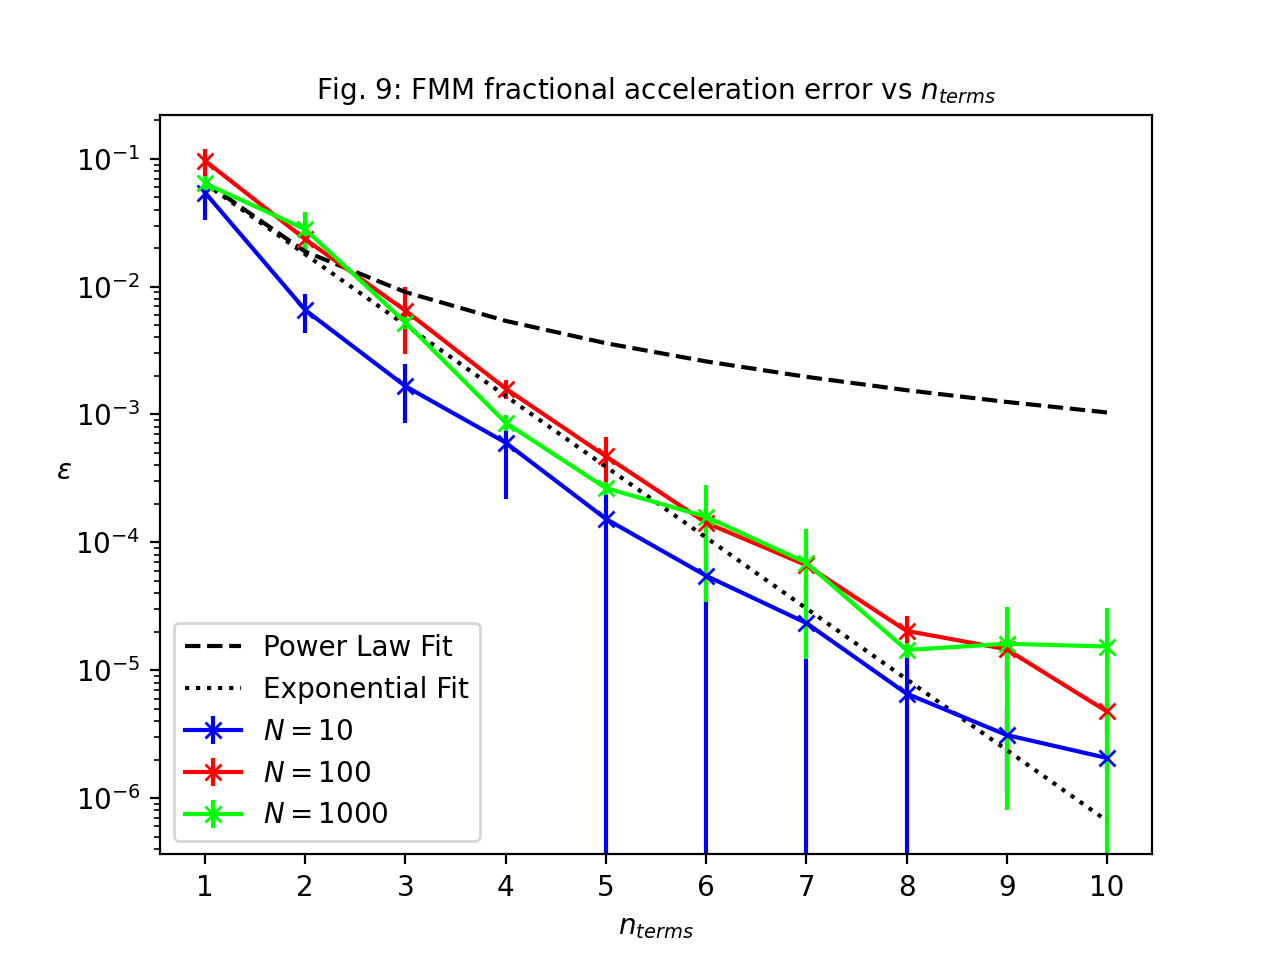

Power law exponent n = -1.7996873989941347 +/- 0.22108410688176056
Exponential parameter b = 0.2793948003444 +/- 0.005823542123775643


In [29]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/FMMAccError.npz')
AccelerationErrorGraphs.FMM_Graph(data)

Performing a similar analysis for the FMM gives the above plot. $\epsilon$ decreases with increasing $n_{\text{terms}}$, but is exponential in $n_{\text{terms}}$ (that is, $\epsilon \propto b^{n_{\text{terms}}}$) instead of following a power law. An exponential relationship is expected in this case [5]. The error is proportional to the lowest-order terms discarded in each expansion, which are proportional to $z^{n_{\text{terms}}+1}$, and therefore to $z^{n_{\text{terms}}}$. Due to the many different values of $z$ used throughout the simulation, all depending on the unique arrangement of particles, it is hard to predict the value of the exponential parameter $b$. This is reflected in the large errorbars on the plot. Nevertheless, this explains the fact that the observed relationship is exponential.

As with the Barnes-Hut algorithm, there is no evidence that $\epsilon$ depends on $N$, although the range of $N$ investigated is limited by the complexity of the Brute Force method.

An additional source of error in the FMM comes from the calculation of the gradient of the potential using Eqn. $(13)$; the accuracy of this depends on the parameter $\delta$. Taylor expanding $\phi(x+\delta,y)$ gives:

$$\phi(x+\delta,y) = \phi(x,y) + \frac{\partial \phi(x,y)}{\partial x}\delta + \frac{1}{2}\frac{\partial^2 \phi(x,y)}{\partial x^2}\delta^2 + \cdots \tag{18}$$

and so the error in Eqn. $(13)$ is proportional to $\delta$.

<IPython.core.display.Javascript object>


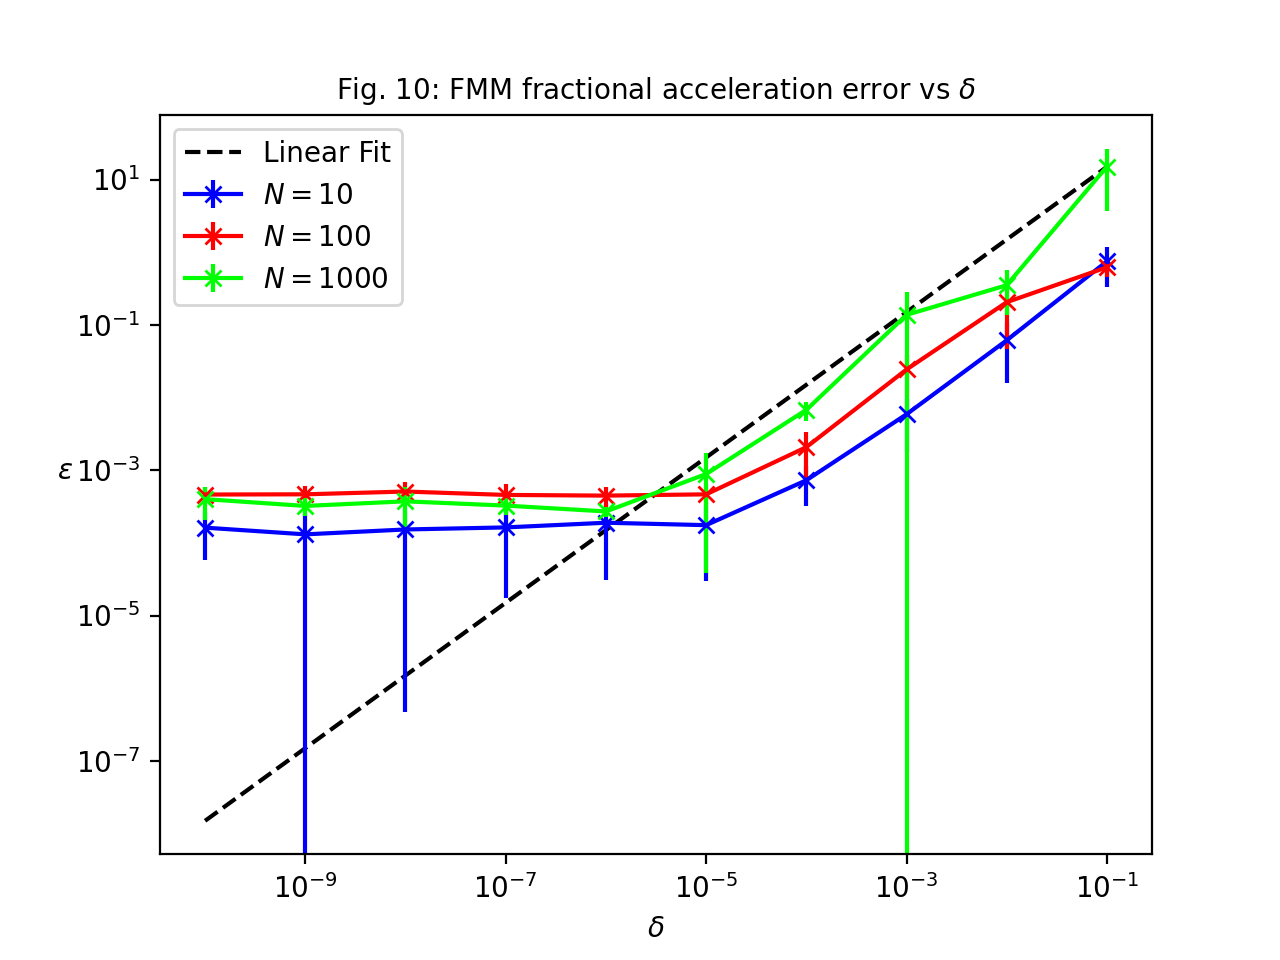

In [30]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/FMMAccErrorVsDelta.npz')
AccelerationErrorGraphs.FMM_Delta_Graph(data)

Above $\delta=10^{-5}$, the linear fit is very good. However, below this value, $\epsilon$ tends to a constant value of $\sim10^{-3}$ (ignoring the variation in the unreliable $N=10$ dataset). This is because the data for Fig. 10 was collected using $n_{\text{terms}}=5$. From Fig. 9, this value of $n_{\text{terms}}$ itself results in an error of $\sim10^{-3}$; this error therefore dominates in Fig. 10 for $\delta<10^{-5}$.

If $\delta$ is the limiting factor, $\epsilon$ can be reduced linearly by reducing $\delta$ down to $\approx10^{-13}$. Below this value, rounding errors start to become significant, due to the computer precision of $\approx10^{-16}$. I used the value $\delta=10^{-10}$ by default in my implementation. This is comfortably large enough that rounding errors are not significant, but small enough that its associated error is smaller than that associated with the chosen values of $n_{\text{terms}}$ ($n_{\text{terms}}=5$ by default). This allows for a fair comparison of the algorithms, instead of the performance of the FMM being affected by an error in this gradient calculation, which really has nothing to do with the algorithm itself.

### 4.2 Execution Time

The scaling of all three algorithms with $N$ was investigated by using the <code>timeit</code> module to to measure the execution time of sections of the code. This was performed on a Macbook Air with a 1.1 GHz Quad-Core Intel Core i5 processor, with 8GB RAM.

#### 4.2.1 Brute Force

<IPython.core.display.Javascript object>


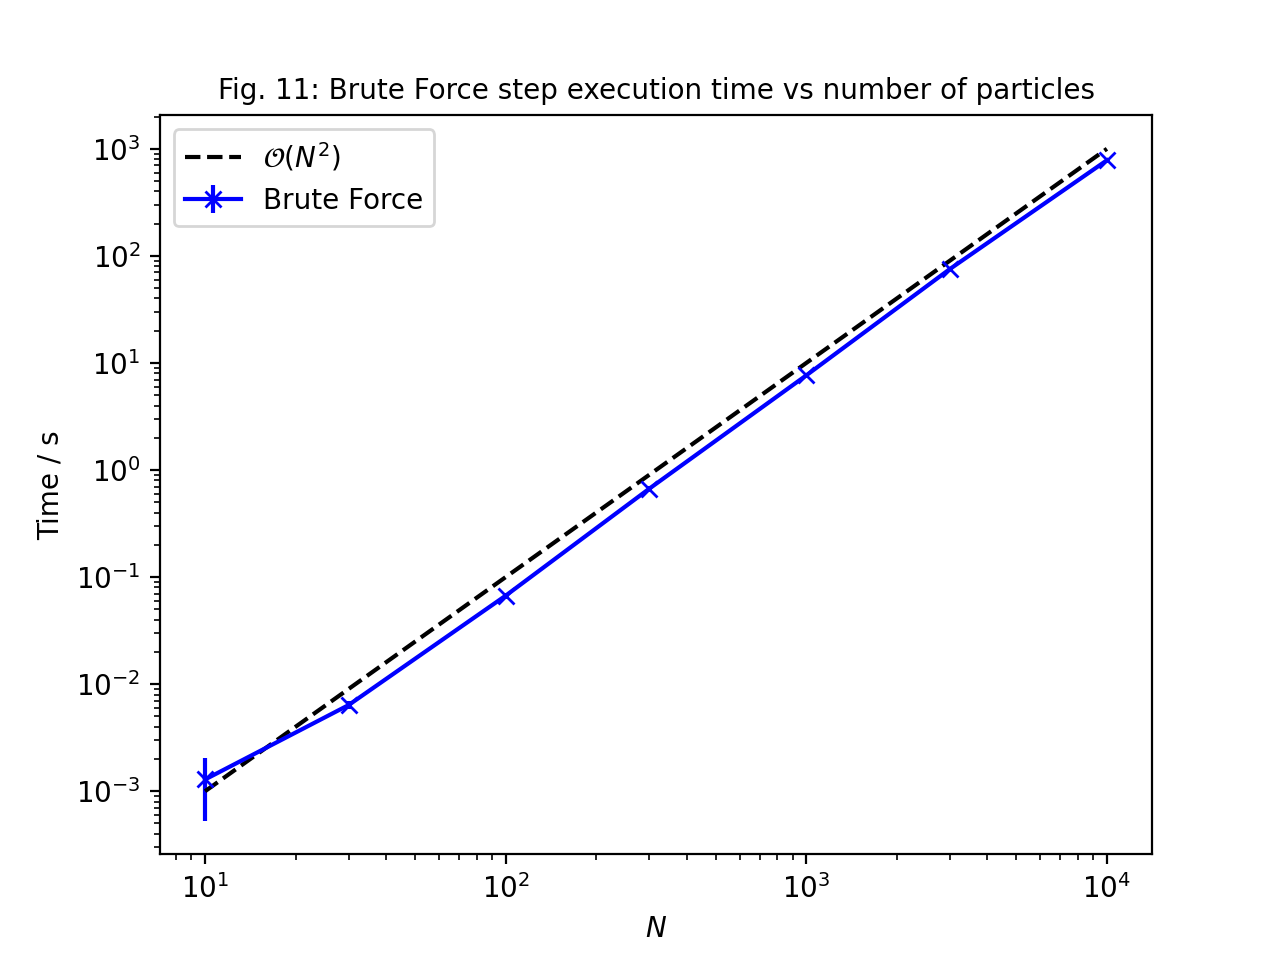

In [31]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/BFStepTime.npz')
StepRuntimeGraphs.BF_Graph(data)

The above plot shows the dependence of the <code>BF_step</code> function execution time on $N$. The time closely follows the predicted $\mathcal{O}(N^2)$ relationship. Due to this poor scaling, simulating systems with $N>10^4$ becomes impractical for the Brute Force method with the computing power of my own laptop. Only values up to $N=10^3$ were used in Section 4.1, since several runs needed to be performed for each value of $N$ in order to obtain the mean and standard deviation of $\epsilon$.

Note that in Fig. 11 and several other plots in this section, the lines plotted to show the scaling with $N$ are not calculated as a fit to the data points. Instead, they are deliberately offset from the data, to allow easy identification of whether the data are parallel to the line, and hence scaling in the same way. Where the trendlines do represent a fit to the data, this will be made clear.

#### 4.2.2 Barnes-Hut

<IPython.core.display.Javascript object>


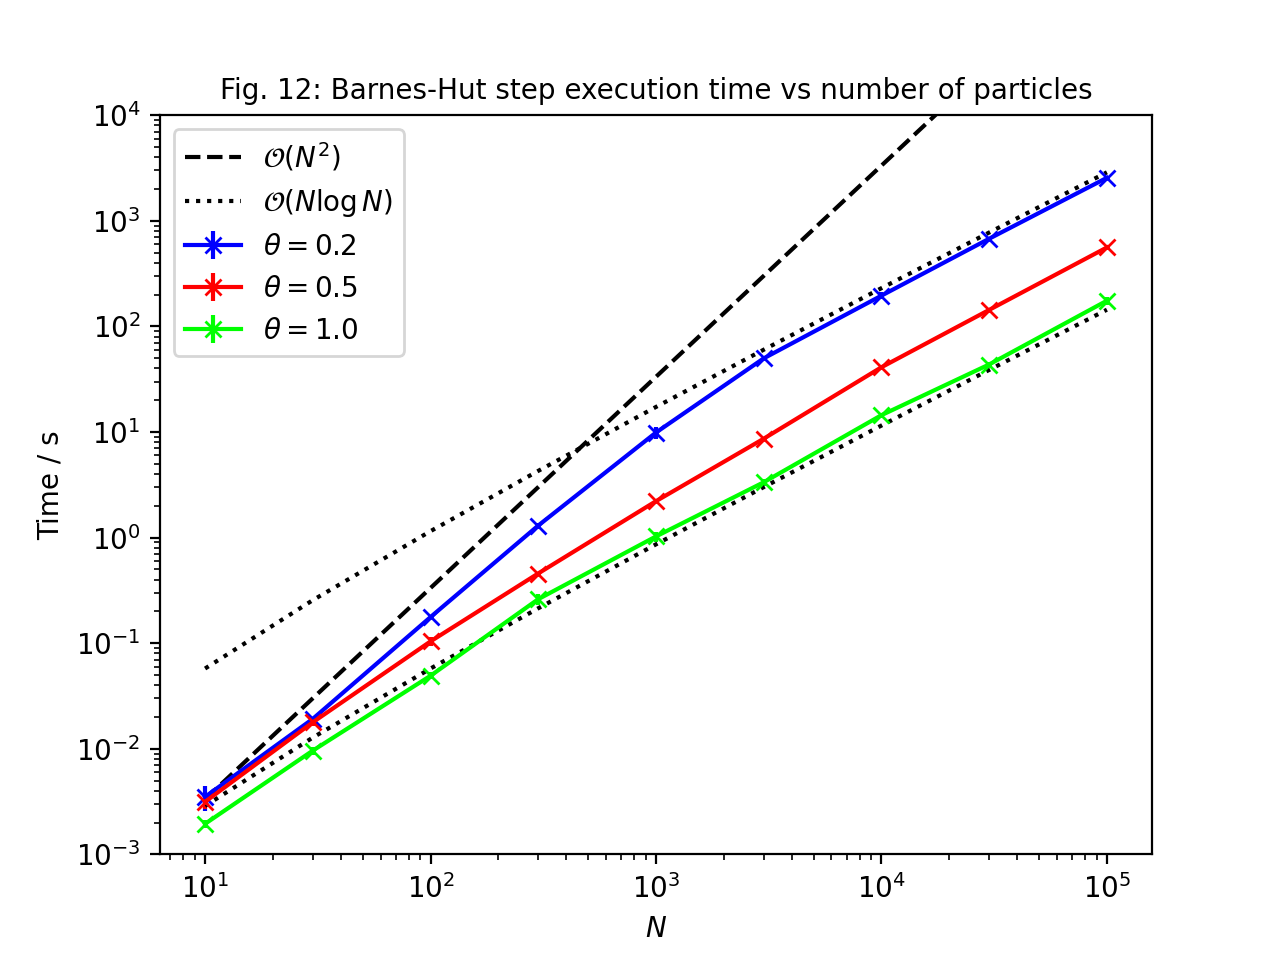

In [32]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/BHStepTime.npz')
StepRuntimeGraphs.BH_Graph(data)

This plot of the <code>BH_step</code> function execution time shows that the Barnes-Hut algorithm far outperforms the $\mathcal{O}(N^2)$ Brute Force method, and scales as $\mathcal{O}(N\log N)$ for large $N$ as predicted. Additionally, the performance depends on the value of $\theta$; larger values of $\theta$ result in a lower execution time and scaling closer to $\mathcal{O}(N\log N)$ at lower $N$, since fewer particle-particle interactions are calculated directly.

To gain more insight, it is useful to individually time the different steps of the algorithm: updating the particle positions, building the quadtree, calculating the accelerations, and finally updating the velocities.

<IPython.core.display.Javascript object>


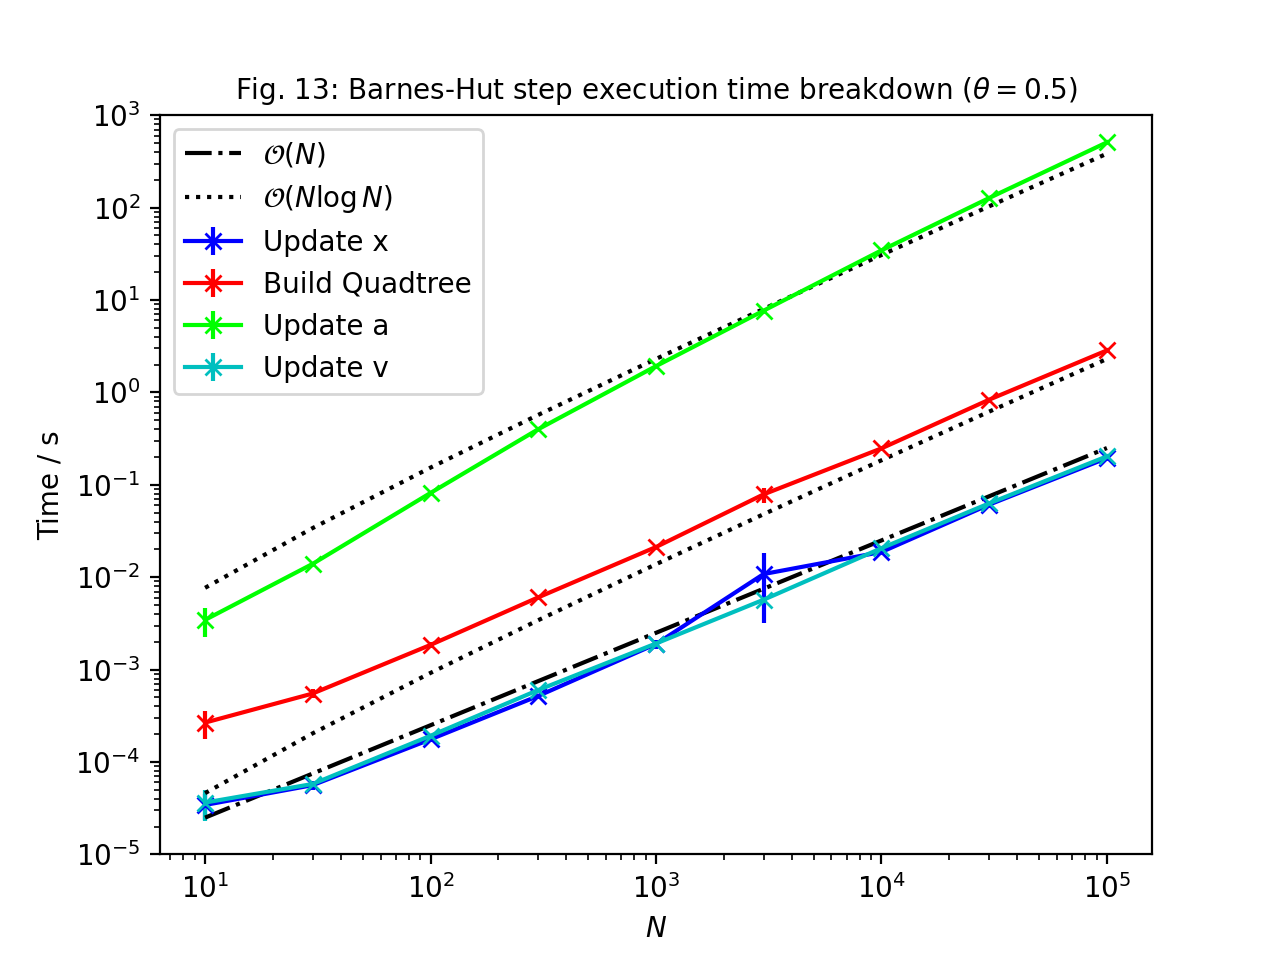

In [33]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/BHComponentTime.npz')
StepRuntimeGraphs.BH_Component_Graph(data)

Updating the positions and velocities follow the expected $\mathcal{O}(N)$ relationship. For large $N$, building the quadtree also scales with the predicted $\mathcal{O}(N\log N)$.

Calculating the accelerations is the step which dominates the overall execution time of the algorithm, taking around two orders of magnitude longer than building the quadtree. It scales slightly worse than $\mathcal{O}(N\log N)$ due to the direct calculation of the potential from the particles and nodes that do not meet the $\frac{L}{r}<\theta$ criterion. As $N$ increases, the number of such direct interactions becomes smaller relative to the total number of particles, so the complexity becomes closer to $\mathcal{O}(N\log N)$, but still slightly exceeds it.

As discussed above, the execution time for a complete step also depends on $\theta$. This dependency is investigated in more detail below.

<IPython.core.display.Javascript object>


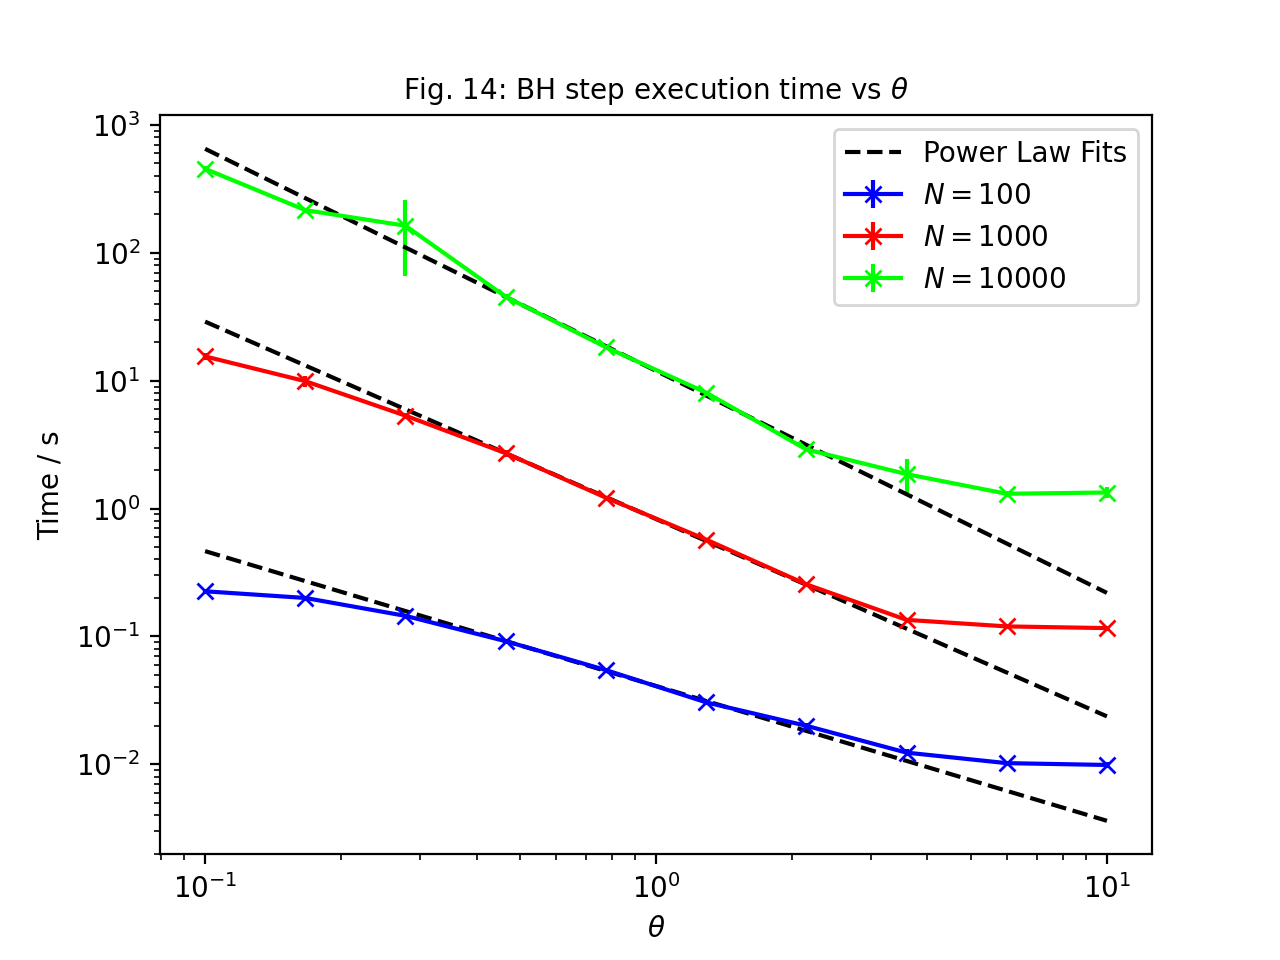

Power law exponent n = -1.054115047765815 +/- 0.03352273065163646
Power law exponent n = -1.5430023949621918 +/- 0.02496749602131677
Power law exponent n = -1.735921036523091 +/- 0.047247537205304814


In [34]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/BHThetaTime.npz')
StepRuntimeGraphs.BH_Theta_Graph(data)

This plot shows a complicated relationship between the execution time and $\theta$. A power law fit to each data set was computed from $\theta=0.46$ to $\theta=2.1$, and fits the data in this range reasonably well for each value of $N$. However, each value of $N$ follows a different power law. The exponents are listed in order of increasing $N$; the larger $N$ is, the more rapidly execution time decreases with increasing $\theta$, because the number of direct interactions decreases by a larger amount with each step in $\theta$. 

Outside this central power law region, the execution time decreases more slowly with $\theta$. This is because at these extreme values of $\theta$, varying $\theta$ does not greatly alter the number of nodes obeying the $\frac{L}{r}<\theta$ condition. 

The theoretical basis for the power law relationship is unclear. However, the key takeaway from this data is that the execution time varies strongly with $\theta$, especially for large $N$. This fact would need to be considered when implementing the Barnes-Hut algorithm; it may be preferable or necessary to choose a lower accuracy level to prevent the computation time from becoming too large.

#### 4.2.3 FMM

<IPython.core.display.Javascript object>


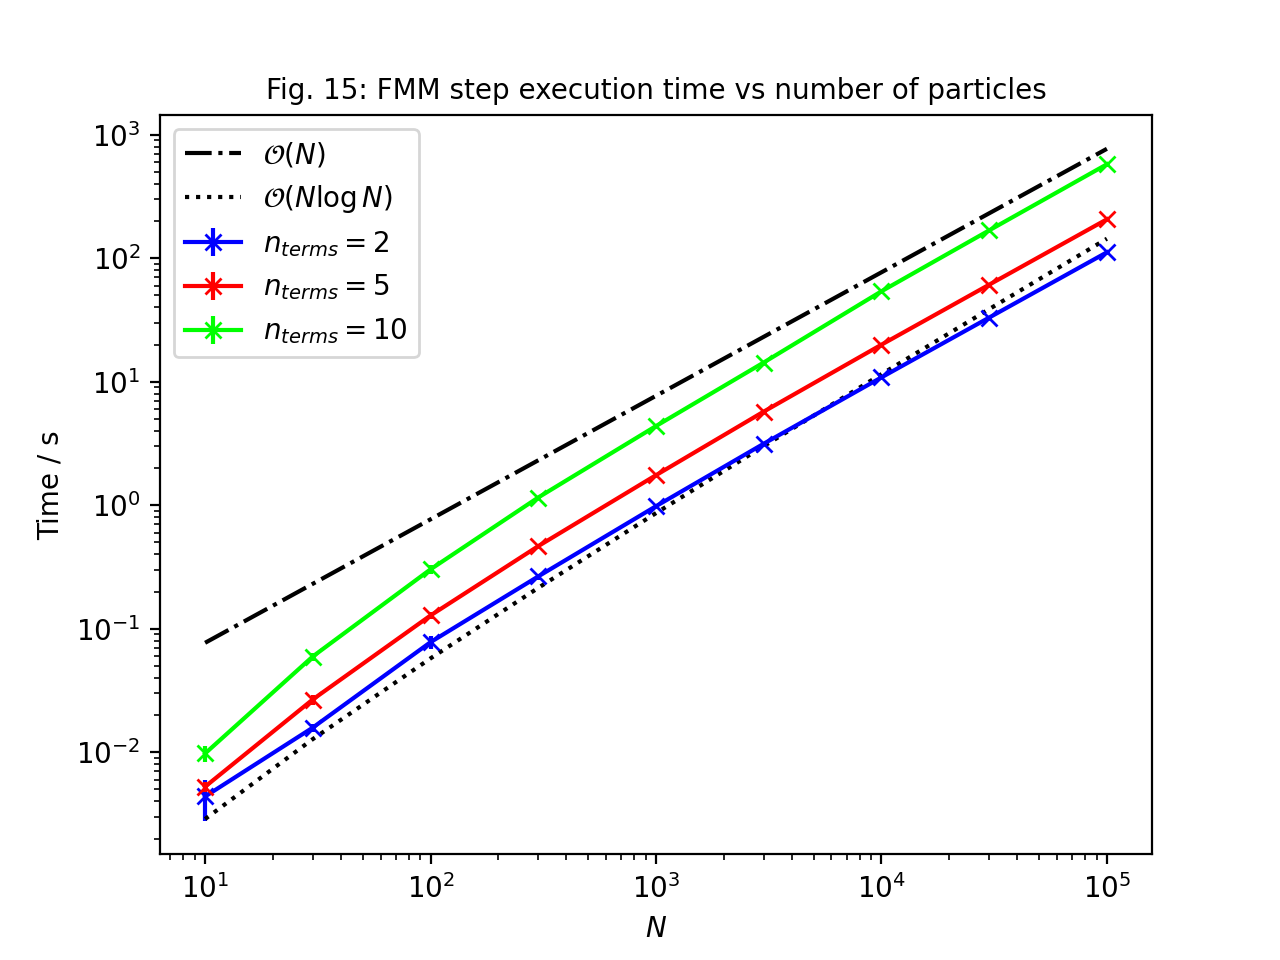

In [35]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/FMMStepTime.npz')
StepRuntimeGraphs.FMM_Graph(data)

Comparing this plot with Fig. 12 shows that the FMM is significantly faster than the Barnes-Hut algorithm. The comparison is most relevant between the curves with $\theta=0.2$ and $n_{\text{terms}}=5$, which correspond to similar errors of $\epsilon \sim 10^{-4}$. The execution time  of the FMM is smaller than that of the Barnes-Hut algorithm by around an order of magnitude.

For large $N$, the measured execution time of the FMM scales as $\mathcal{O}(N)$. This indicates that, over the range of $N$ tested here, the $\mathcal{O}(N\log N)$ step to build the quadtree does not dominate the execution time of the algorithm, despite its higher complexity. To verify this, the times taken for the individual steps were plotted as for the Barnes-Hut algorithm. As well as the Barnes-Hut steps, the FMM requires updating the near neighbours, direct nodes and interaction sets of each node (grouped together as the 'update lists' step), and computing the outer and inner expansion coefficients for each node. 

<IPython.core.display.Javascript object>


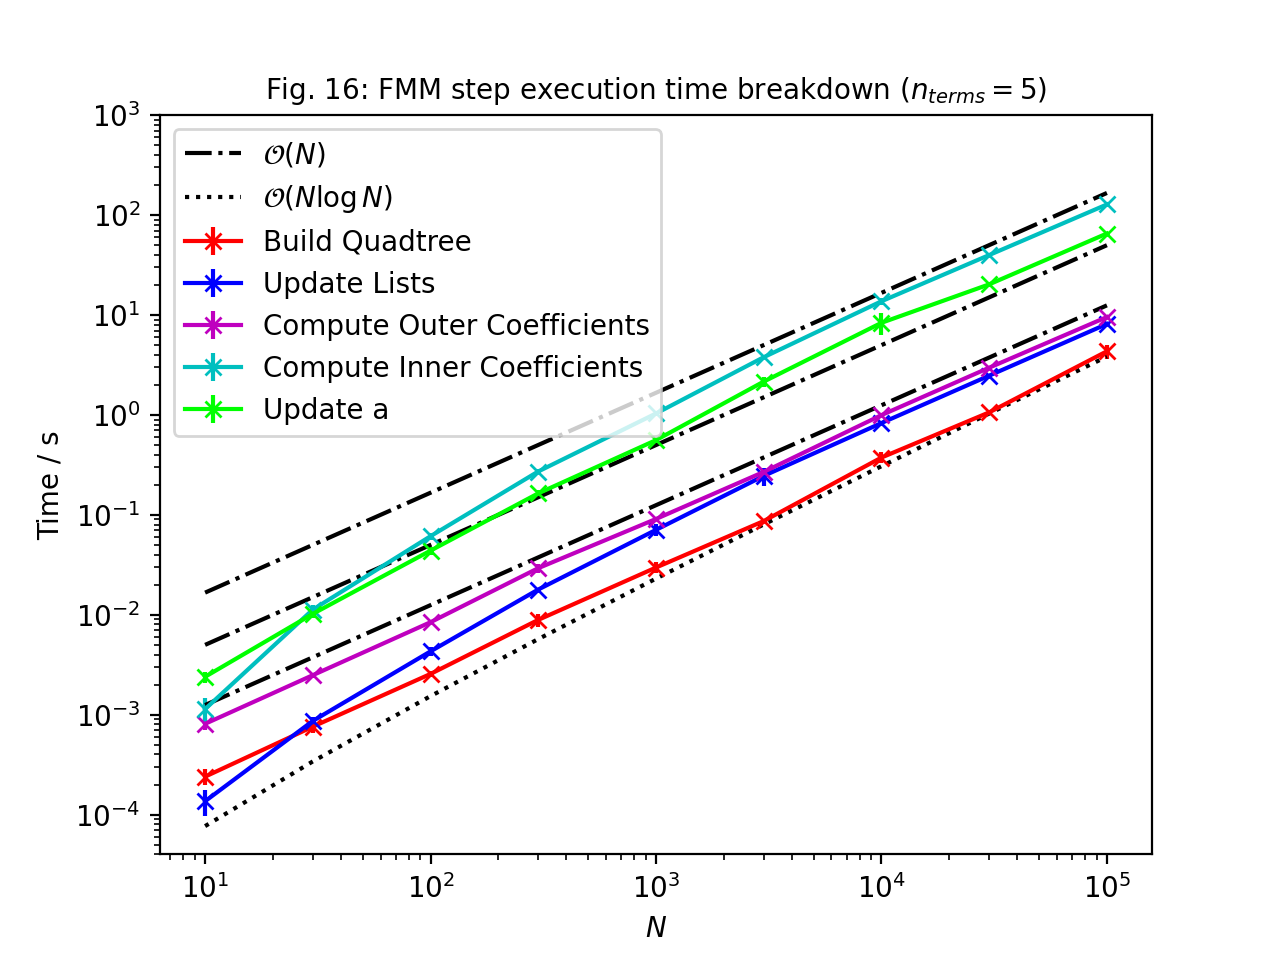

In [36]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/FMMComponentTime.npz')
StepRuntimeGraphs.FMM_Component_Graph(data)

Updating the positions and velocities were $\mathcal{O}(N)$ as for the Barnes-Hut algorithm, and were left off the plot for clarity. The plot clearly shows all the steps following the predicted complexities from Section 2.3, with building the quadtree $\mathcal{O}(N\log N)$ and all others tending to $\mathcal{O}(N)$. The scaling is worse than this for some of the steps at low $N$ due to the number of particles in near neighbours and direct nodes being a significant fraction of $N$.

As expected from Fig. 15, despite the higher $\mathcal{O}(N\log N)$ complexity, building the quadtree does not dominate the execution time of the algorithm; instead, computing the inner expansion coefficients does. Extrapolating the trendlines suggests that building the quadtree will only dominate for $N\gtrsim10^{200}$. The age of the universe is only $\sim10^{17}\text{s}$, and so for all practical purposes, building the quadtree will never dominate and the FMM has overall complexity of $\mathcal{O}(N)$.

As mentioned in Section 2.3, calculating the particle accelerations does not dominate the execution time, and so using the inefficient numerical differentiation procedure does not have an overwhelming impact on the total execution time of the algorithm. However, calculating the accelerations does take a significant amount of time (roughly half the time of the longest step, computing the inner expansion coefficients), and so implementing the analytical differentiation method in future work would be worthwhile.

The execution time of the entire step also depends on $n_{\text{terms}}$. This relationship is plotted in the figure below.

<IPython.core.display.Javascript object>


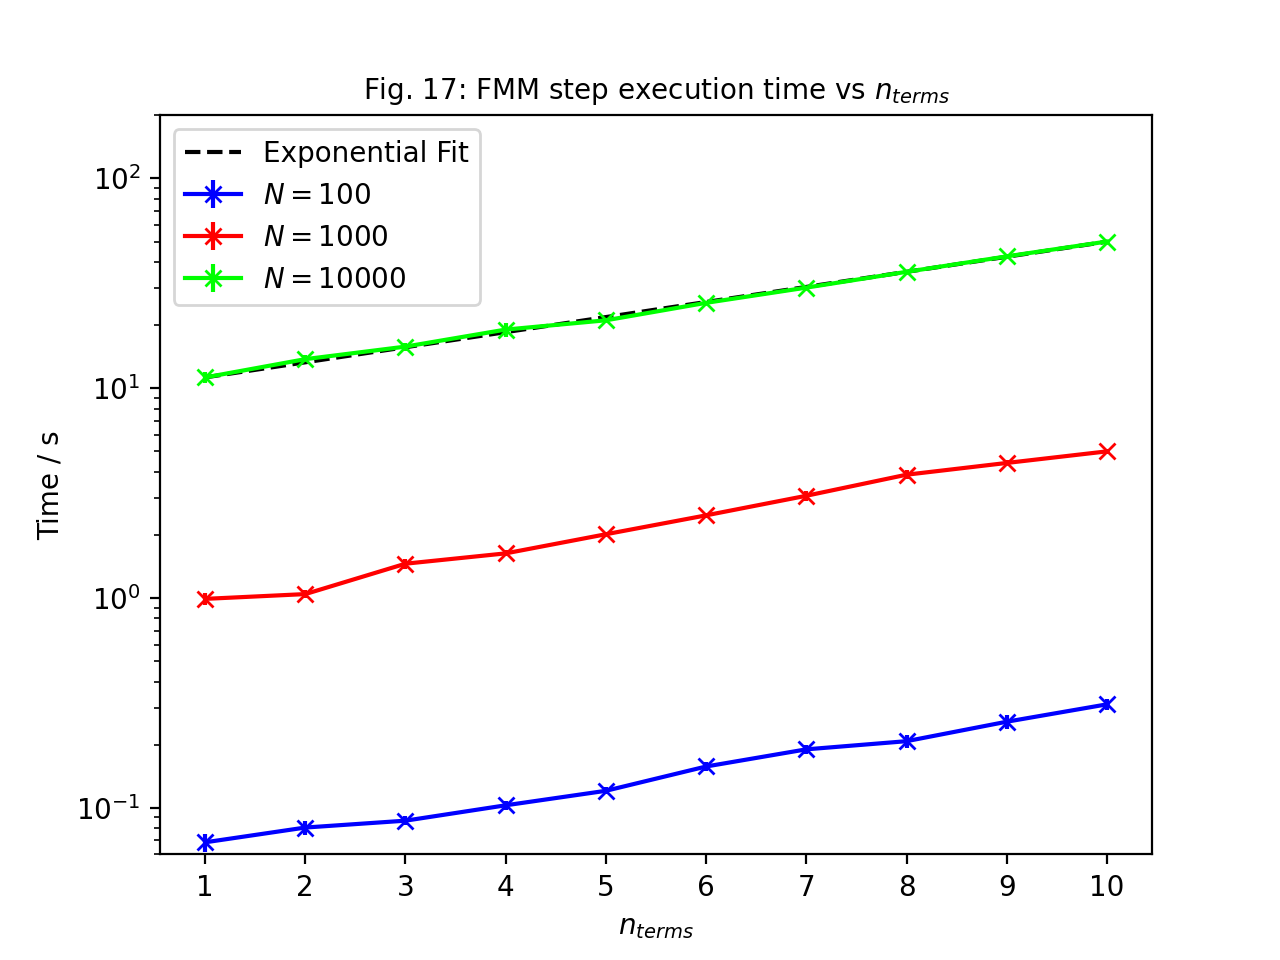

Exponential parameter b = 1.1799356363326214 +/- 0.00221985341657536


In [37]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/FMMNtermsTime.npz')
StepRuntimeGraphs.FMM_nterms_Graph(data)

The plot shows that the relationship between execution time and $n_{\text{terms}}$ is exponential, with the fit calculated to have $b\approx1.2$, independent of $N$. This is surprising, given none of the individual steps  appear to have a complexity that is exponential in $n_{\text{terms}}$; instead, all of Eqn.s $(5)$-$(12)$ involve a total number of calculations of either $\mathcal{O}(n_{\text{terms}})$ or $\mathcal{O}(n_{\text{terms}}^2)$. I believe that the observed exponential relationship is an approximate, effective relationship that only applies at these relatively low values of $N$ and $n_{\text{terms}}$, but this hypothesis would need to be investigated further.

Regardless, the fact that $b$ is so close to $1$ means that for practical purposes, $n_{\text{terms}}$ can be increased as required to give the desired level of accuracy without having a particularly significant effect on the execution time of the algorithm. This is in contrast to the Barnes-Hut algorithm, in which improving accuracy by decreasing $\theta$ comes at significant cost to the execution time.

### 4.3 Leapfrog Accuracy

The accuracy of the Leapfrog integration depends on the parameter $dt$. This does not affect the accuracy of the accelerations calculated by any of the algorithms (only the velocities and positions subsequently calculated from the accelerations), and so comparing the performance of the algorithms is valid even with a poorly chosen $dt$. Nevertheless, it is worthwhile to investigate what value is required for $dt$ to produce physically realistic simulations. This enables the code produced in this work to be immediately applied in future situations where the true accuracy of the simulations, not just accuracy relative to the Brute Force calculations, is of importance.

<IPython.core.display.Javascript object>


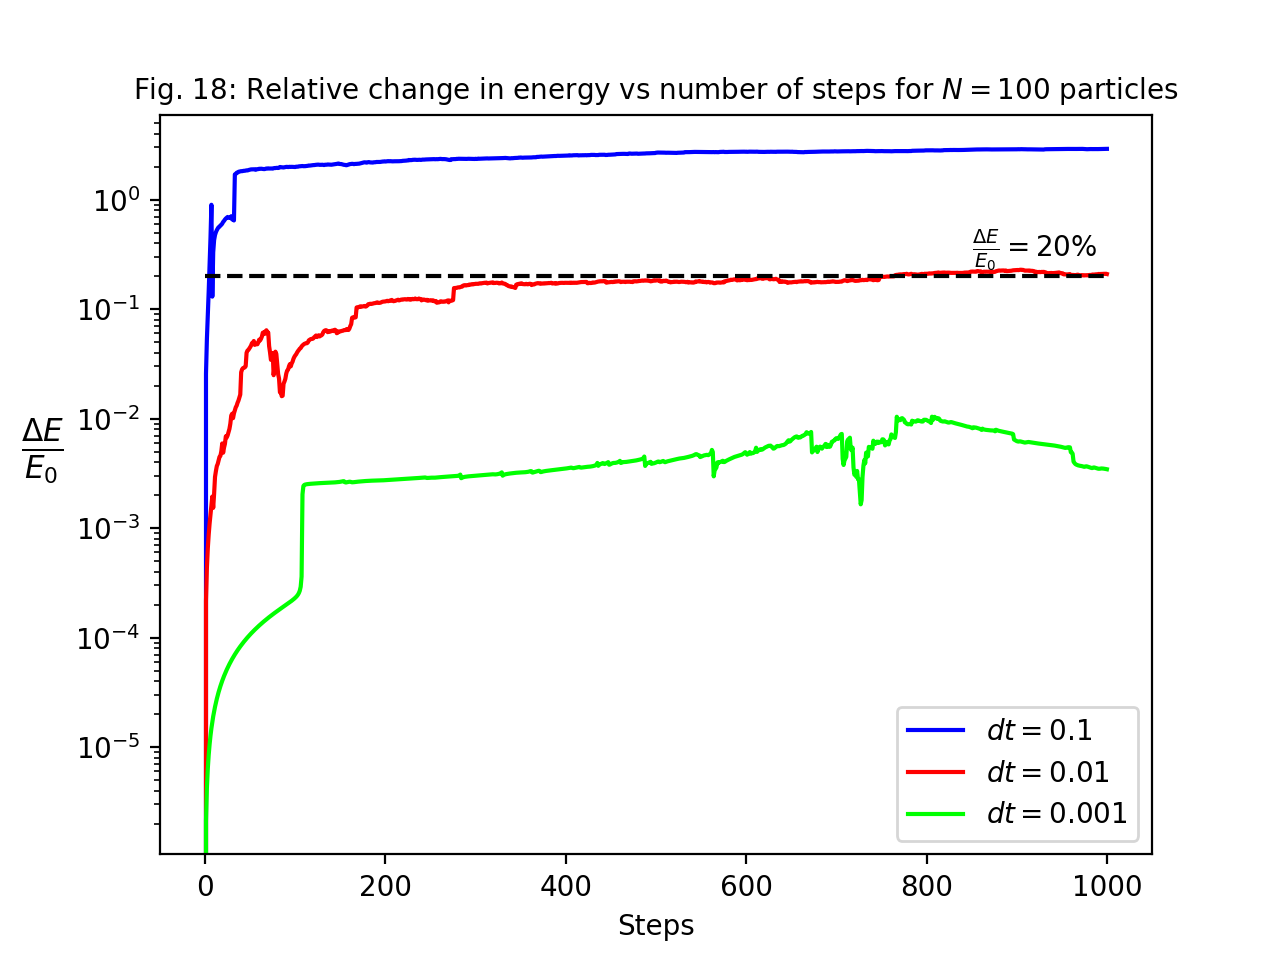

In [38]:
data = np.load('/Users/benburgess/Documents/GitHub/computing-project-benburgess1/Analysis/EnergyConservation.npz')
EnergyConservationGraphs.Energy_Graph(data)

The graph above shows the fractional change in energy with time for different values of $dt$. This was computed using the Brute Force method to avoid any errors due to inaccuracies in the Barnes-Hut or FMM algorithms. In this work, the value $dt=0.01$ was chosen, despite its error tending to $\sim20\%$ after a large number of steps. This was so that the simulations produced would evolve to a later time with less computational effort than if a smaller, more accurate value of $dt$ were chosen. If the accuracy of the simulations was of importance, then a value of $dt<0.001$ ought to be used.

## 5. Conclusions

This work has implemented the Barnes-Hut algorithm and the Fast Multipole Method, and compared their performance. Both algorithms were used to produce simulations which closely resemble those produced by the Brute Force method. The accuracy of the algorithms depends on the choice of the parameters: $\theta$ for the Barnes-Hut algorithm, and $n_{\text{terms}}$ and $\delta$ for the FMM. For $N$ particles, the dominant contributions to the execution times of the algorithms scale as $\mathcal{O}(N\log N)$ and $\mathcal{O}(N)$ respectively, and so both algorithms represent a significant improvement over the $\mathcal{O}(N^2)$ Brute Force method. For a given accuracy level, the FMM is significantly quicker than the Barnes-Hut algorithm (by a factor of $\approx10$ at $\epsilon\sim10^{-4}$), and so for most applications, the FMM is likely to be preferred. Additionally, the accuracy of the FMM can be improved without significant cost to its execution time, which is not the case for the Barnes-Hut algorithm. Advantages of the Barnes-Hut algorithm are that it is simpler to implement and debug, particularly for the 3D $\frac{1}{r}$ potential, which was not implemented in this work for the FMM.

This work could be extended in a number of ways. Firstly, there are several ways that the algorithms could be improved. The quadtree could be stored and only the relevant parts updated, where a second particle moves into a node that was previously a leaf. The accuracy of the Barnes-Hut algorithm could be improved by calculating the dipole and higher order terms for each node. The execution time could also be improved by implementing the algorithms in Cython. Secondly, throughout this report, the algorithms' performance was compared using random distributions of particles; it would be interesting to compare the algorithms for non-random distributions found in physical situations, such as the non-uniform distribution of stars in a galaxy. Finally, it would also be useful to implement the FMM using the 3D $\frac{1}{r}$ potential and compare the performance of the algorithms in this case, since this is the potential required for application of the algorithms in astronomy.

### References

[1] Davis P. & Carney S. (2023, March 22). _Beyond our Solar System_. Retrieved from https://solarsystem.nasa.gov/solar-system/beyond/overview/

[2] Barnes, J. & Hut, P. (1986). A hierarchical $\mathcal{O}(N\log N)$ force-calculation algorithm. _Nature, 324_, 446-449.

[3] Beatson, R. & Greengard L. (1997). A short course on fast multipole methods. Retrieved from https://math.nyu.edu/~greengar/shortcourse_fmm.pdf

[4] Demmel, J. (1996). Fast hierarchical methods for the N-body problem, part 2. Retrieved from https://people.eecs.berkeley.edu/~demmel/cs267/lecture27/lecture27.html

[5] Martinsson, P. (2012). Fast Multipole Methods. In B. Engquist (ed.), _Encyclopedia of Applied and Computational Mathematics_. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-70529-1_448

[6] Young, P. (2014). The leapfrog method and other "symplectic" algorithms for integrating Newton's laws of motion. Retrieved from https://young.physics.ucsc.edu/115/leapfrog.pdf

[7] Grudic, M. (2017, July 11). _A simple and pythonic Barnes-Hut treecode_. Retrieved from https://mikegrudic.wordpress.com/2017/07/11/a-simple-and-pythonic-barnes-hut-treecode/

[8] Barroso-Luque, L. (2020, January 24). _fmm_ [GitHub repository]. Retrieved from https://github.com/lbluque/fmm